##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024

## TP2: Plongements de mots

## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- membre 1 (% de contribution, nature de la contribution)
- membre 2 (% de contribution, nature de la contribution)
- membre 3 (% de contribution, nature de la contribution)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

### Objectif du TP

L'objectif de ce TP est d'entraîner un modèle de plongements lexicaux qui intègre des notions de synonymie et d'antonymie en utilisant des réseaux de neurones. 

Contrairement aux plongements vus en cours comme GloVe ou Word2Vec, qui positionnent souvent les mots à proximité équivalente de leurs synonymes et antonymes, nous chercherons à faire distinguer à nos modèles les synonymes et antonymes, en rapprochant les mots de leurs synonymes et en les éloignant de leurs antonymes.

### Jeux de données

**Paires de synonymes et antonymes** (entraînement) : Les fichiers `train_synonyms.txt` et `train_antonymms.txt` contiennent les paires de synonymes et d'antonymes qui serviront à l'entraînement de nos modèles.
- train_synonyms: ~640k paires de synonymes
- train_antonyms: ~12k paires d'antonymes

**SimLex-999** (test) : Le fichier `simlex_english.txt` contient 1000 paires de mots et leur similarité entre 0 et 10. Des antonymes auront une similarité de 0 et des mots proches auront une similarité plus élevée. Par exemples :

- *nice* & *cruel* -> 0
- *violent* & *angry* -> 5.9
- *essential* & *necessary* -> 9.8

### Développement du TP

Le TP suivra les étapes suivantes:

- Partie 1 : Familiarisation avec GloVe, modèle de plongements de mots pré-entraîné
- Partie 2 : Évaluation de GloVe sur SimLex-999
- Partie 3 : Mise en place de la méthode d'entraînement
- Partie 4 : Entraînement de zéro (baseline)
- Partie 5 : Entraînement utilisant GloVe pré-entraîné et conclusion

Le TP est noté sur 89 points.

### Librairies autorisées

+ numpy
+ pandas
+ torch
+ matplotlib

Si vous voulez utiliser une autre librairie, veuillez demander à votre chargé de lab.

### Imports

Les imports effectués dans la cellule suivante devraient être suffisants pour faire tout ce TP.

In [1]:
from tqdm import tqdm
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

### 1. GloVe (10 Points)

Dans ce TP, nous allons utiliser le modèle pré-entraîné GloVe qui crée des plongements lexicaux de mots.

#### 1.1 Chargement du modèle

La cellule suivante permet charger le modèle GloVe pré-entraîné. Le chargement du modèle peut prendre quelques minutes.

In [2]:
# # Décommenter pour télécharger les GloVe embeddings à partir de https://nlp.stanford.edu/projects/glove/
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip -P /content
# !unzip /content/glove.42B.300d.zip -d /content

In [3]:
pretrained_model_path = 'glove.42B.300d.txt'

data_root = 'data'

train_synonyms_path = f"{data_root}/train_synonyms.txt"
train_antonyms_path = f"{data_root}/train_antonyms.txt"

eval_simlex = f'{data_root}/simlex_english.txt'

In [4]:
def load_word_vectors(filepath, vocab=None):
    """
    Télécharge le modèle pré-entraîné de plongements de mots en pytorch
    """
    word_to_index = {}
    embeddings = []
    index = 0

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            if vocab is None or word in vocab:
                embedding = np.array(split_line[1:], dtype=np.float32)
                word_to_index[word] = index
                embeddings.append(embedding)
                index += 1
    
    embeddings = np.stack(embeddings)
    embeddings = torch.from_numpy(embeddings)
    return word_to_index, embeddings

In [5]:
word_to_index, embeddings = load_word_vectors(pretrained_model_path)

#### 1.2 Implémentez la fonction `cosine_similarity` avec pytorch et sans utiliser `torch.nn.CosineSimilarity` (2 points)

In [6]:
def cosine_similarity(a, b):
    """
    Calcule la matrice de similarité cosinus entre deux matrices

    Args :
        a   : torch.Tensor, shape=(n, d)
        b   : torch.Tensor, shape=(m, d)

    Returns:
    torch.Tensor, shape=(n, m)
    """

    num = torch.mm(a, b.t())

    a_norm = torch.linalg.norm(a, dim=1, keepdim=True)
    b_norm = torch.linalg.norm(b, dim=1, keepdim=True)

    denom = a_norm*b_norm.t()


    return num / denom


    # TODO
    # END TODO

In [7]:
#A = torch.Tensor([[0,1,0,5],
#                  [1,2,5,6]])
#B = torch.Tensor([[-1,0,-5,0],
#                  [9,7,2,5],
#                  [4,7,0,9]])
#cosine_similarity(A,B)
#tensor([[ 0.0000,  0.4977,  0.8440],
#        [-0.6276,  0.6150,  0.7335]])

#### 1.3 Complétez la fonction `n_closest_vect` qui retourne les n mots les plus proches d'un mot donné. (5 points)

`n_closest_vect` prendra en entrée la matrice des plongements `embeddings`, le dictionnaire de correspondance entre les mots et les indices `word_to_index`, le plongement d'un mot `word` et le nombre `n` de mots attendus. La fonction devra retourner la liste des mots dont les plongements sont les plus proches du vecteur de référence et leur similarité cosinus.

C'est-à-dire les n mots avec lesquels le mot a la plus grande similarité cosinus. Utilisez la fonction `cosine_similarity` que vous venez d'implémenter.

In [8]:
def n_closest_vect(embeddings, word_to_index, wordEmbedding, n=5):
    """
    Trouve les n mots les plus proches du vecteur donné et leur similarité

    Args : 
        embeddings      : torch.Tensor, shape=(vocab_size, embedding_dim)
        Matrice de plongement de tous les mots

        word_to_index   : dict
        Dictionnaire qui relie un mot à son index dans le vocabulaire

        wordEmbedding   : torch.Tensor, shape=(embedding_dim,)
        Plongement du mot dont on cherche les n mots les plus proches

        n               : int, number of closest words to return
        Nombre de mots à retourner

    Returns:
    Liste de tuple contenant les n mots les plus similaires avec leur coefficient
    de similarité
    """ 

    cosine_matrix = cosine_similarity(embeddings, wordEmbedding.unsqueeze(0))
    cosine_matrix.squeeze_()

    top_n_values = torch.topk(cosine_matrix, 5)

    top_n_words = {}

    i = 0
    word_keys = list(word_to_index.keys())
    for indice in top_n_values.indices:
      word_value = word_keys[indice]
      top_n_words[word_value] = top_n_values.values[i].item()
      i += 1
    
    return top_n_words


In [9]:
"""     wordEmbedding = torch.reshape(wordEmbedding, (1,-1))
    # Evaluate the matrix 
    similarityVector = cosine_similarity(wordEmbedding,embeddings) # (1,len(word_to_index))
    similarityVector = torch.reshape(similarityVector,(len(word_to_index),))
 
    idxSorted = np.argsort(similarityVector)
    
    
    # Only keep the first N
    outWords = []
    for i in range(n):
        outWords += [(list(word_to_index.keys())[idxSorted[-1-i]],
                      float(similarityVector[idxSorted[-1-i]]))]
    return outWords """

'     wordEmbedding = torch.reshape(wordEmbedding, (1,-1))\n    # Evaluate the matrix \n    similarityVector = cosine_similarity(wordEmbedding,embeddings) # (1,len(word_to_index))\n    similarityVector = torch.reshape(similarityVector,(len(word_to_index),))\n \n    idxSorted = np.argsort(similarityVector)\n    \n    \n    # Only keep the first N\n    outWords = []\n    for i in range(n):\n        outWords += [(list(word_to_index.keys())[idxSorted[-1-i]],\n                      float(similarityVector[idxSorted[-1-i]]))]\n    return outWords '

In [10]:
# Exemple

print(n_closest_vect(embeddings, word_to_index, embeddings[word_to_index['morning']]))

{'morning': 0.9999999403953552, 'afternoon': 0.8665473461151123, 'evening': 0.7880070805549622, 'yesterday': 0.7614548206329346, 'sunday': 0.7548925876617432}


Sortie attendue :
```
[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]
```

#### 1.4 Quelle est la similarité cosinus entre 'fast' et 'slow' ? Entre 'fast' et 'rapid' ? Commentez les résultats et expliquez leur origine. (3 points)

In [11]:
nDim = 300
fastEmbedding = torch.reshape(embeddings[word_to_index['fast']],(1,nDim))
slowEmbedding = torch.reshape(embeddings[word_to_index['slow']],(1,nDim))
rapidEmbedding = torch.reshape(embeddings[word_to_index['rapid']],(1,nDim))

fastSlowRapidSimilarity = cosine_similarity(fastEmbedding, torch.cat((slowEmbedding,rapidEmbedding),0))

print(f'{"":^10} |{"slow":^10} |{"rapid":^10}')
fastSlowStr = f'{float(fastSlowRapidSimilarity[0,0]):.5f}'
fastRapidStr = f'{float(fastSlowRapidSimilarity[0,1]):.5f}'
print(f'{"fast":^10} |{fastSlowStr:^10} |{fastRapidStr:^10}')

           |   slow    |  rapid   
   fast    | 0.71137   | 0.64453  


### 2. Évaluation (12 Points)

#### Données

Les cellules qui suivent permettent de télécharger les données et de se restreindre au vocabulaire qui nous sera utile, pour éviter de charger des plongements inutiles.

Comme décrit dans l'introduction, nous avons 3 fichiers de données:
- Des paires de synonymes pour l'entraînement (`train_synonyms.txt`) 
- Des paires d'antonymes pour l'entraînement (`train_antonymms.txt`)
- Des paires de mots avec leur similarité pour l'évaluation (`simlex_english.txt`)

In [12]:
def load_data(filepath):
    """
    Télécharge les paires de synonymes et antonymes
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            pair = line.strip().split()
            assert pair[0].startswith('en_') and pair[0].startswith('en_')
            data.append((pair[0][3:], pair[1][3:]))
    return data

def data_to_tensor(data, word_to_index):
    indices = [word_to_index[word] for pair in data for word in pair if word in word_to_index]
    return torch.tensor(indices).view(-1, 2)

In [13]:
# Données d'entraînement
train_synonyms = load_data(train_synonyms_path)
train_antonyms = load_data(train_antonyms_path)

# Données d'évaluation
evaluation_simlex = pd.read_csv(eval_simlex, sep='\t') # pd dataframe with columns 'word 1', 'word 2', 'score'

# On se restreint au vocabulaire qu'on va utiliser pour éviter de charger des embeddings inutiles
vocab = set([word for pair in train_synonyms + train_antonyms for word in pair])
eval_vocab = set(evaluation_simlex['word 1']).union(set(evaluation_simlex['word 2']))
vocab.update(eval_vocab)

glove_word_to_index, glove_embeddings = load_word_vectors(pretrained_model_path, vocab)

#### 2.1 Observation du jeu de données SimLex-999. (2 points)

Affichez l'histogramme de fréquence des scores de similarité dans le jeu de données SimLex-999. Utilisez `bins=40`. Votre axe des x doit représenter le score de similarité et votre axe des y doit représenter la fréquence. Comment interpréter un score de 0?

Text(0.5, 0, 'Score')

<Figure size 640x480 with 0 Axes>

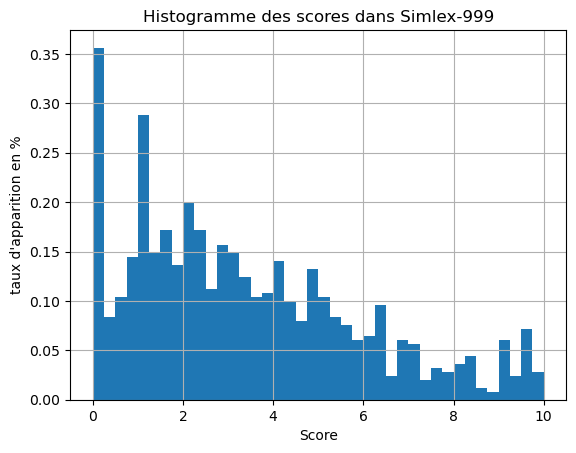

In [14]:
plt.figure()
evaluation_simlex.hist('score',bins = 40,density = True)
plt.title("Histogramme des scores dans Simlex-999")
plt.ylabel("taux d'apparition en %")
plt.xlabel("Score")

#### 2.2 Corrélation de Spearman


La corrélation de Spearman est une mesure de la relation monotone entre deux variables $x$ et $y$. Elle est comprise entre -1 et 1. Plutôt que de comparer les valeurs brutes des variables, elle compare leurs rangs. Elle est calculée comme suit :
$$\rho (x, y) = 1 - \frac{6 \sum_{i=1}^n (r_{x_i} - r_{y_i})^2}{n(n^2 - 1)}$$
où $r_{x_i}$ est le rang de la i-ème valeur de la variable x, $r_{y_i}$ est le rang de la i-ème valeur de la variable y, $n$ est le nombre total de paires d'observations $(x, y)$.

Les rangs sont attribués en ordonnant les valeurs de chaque variable du plus petit au plus grand. La plus petite valeur reçoit le rang 1, la suivante le rang 2, et ainsi de suite.

##### Expliquez pourquoi on utilise la corrélation de Spearman plutôt que la corrélation entre les valeurs des variables. (3 points)


#### 2.3 Implémentation de la corrélation de Spearman (2 points)

Complétez la fonction suivante pour calculer la corrélation de Spearman entre deux listes de valeurs.

In [15]:
def spearman_rank_correlation(x, y):
    """
    Calcule la corrélation de Spearman entre deux listes de valeurs.

    Args:
        x   : list of float
        y   : list of float

    Returns:
    La corrélation de Spearman entre les deux listes (float). 
    """
    N = len(x)
    x = np.array(x)
    y = np.array(y)
    x_y = x-y
    factor = 6 / (N * ( (N ** 2) - 1))
    return 1 - factor * np.dot(x_y,x_y)


In [16]:
# spearman_rank_correlation([1,3,4,2],[2,1,4,3]) = 0.4

#### 2.4 Évaluation du modèle GloVe (2 points)


Retrouvez les plongements du modèle GloVe de tous les mots du jeu de données SimLex-999, puis calculez la similarité cosinus entre les paires.

Calculez ensuite la corrélation de Spearman entre les scores de simlex et les similarités cosinus obtenues et affichez-la.

In [17]:
similarityBetweenPairs = pd.DataFrame({"word 1" : list(evaluation_simlex["word 1"]),
                                       "word 2" : list(evaluation_simlex["word 2"])})

In [18]:
def getRank(array):
    order = array.argsort()
    return order.argsort()

In [19]:
# Calculate similarity between pairs
score = []
for i in range(len(similarityBetweenPairs)):
    score.append(float(cosine_similarity(
        torch.reshape(glove_embeddings[glove_word_to_index[similarityBetweenPairs['word 1'][i]]],(1,-1)),
        torch.reshape(glove_embeddings[glove_word_to_index[similarityBetweenPairs['word 2'][i]]],(1,-1))
    )))
similarityBetweenPairs['score'] = pd.Series(score)

# Evaluate the rank (1 = lowest score, N = highest score)
similarityBetweenPairs['rank'] = getRank(similarityBetweenPairs['score'])
evaluation_simlex['rank'] = getRank(evaluation_simlex['score'])

In [20]:
# Evaluate Spearman correlation
spearman_rank_correlation(similarityBetweenPairs['rank'],
                          evaluation_simlex['rank'])

0.29230790710550225

Résultat attendu: 0.29

#### 2.5 Interprétation du résultat (3 points)

Qu'est ce que ce nombre représente et que peut-on en conclure sur la qualité des plongements GloVe (2 conclusions) ?

### 3. Description de la méthode contrastive (33 Points)

Nous allons maintenant implémenter une méthode contrastive de plongements de mots. Elle vise à améliorer les plongements lexicaux de mots en tenant compte des synonymes et antonymes. 

Notre modèle se basera simplement sur une matrice de plongements de mots, qui associe à chaque mot un vecteur de plongement.

L'idée est d'entraîner ce modèle à rapprocher les plongements de synonymes et d'éloigner ceux d'antonymes.

La cellule suivante définit le modèle et ses attributs.

In [21]:
class ContrastiveWordEmbeddingModel(nn.Module):
    def __init__(self, embeddings, device='cpu', margin_plus=0.6, margin_minus=0., regularization=1e-9):
        super(ContrastiveWordEmbeddingModel, self).__init__()
        
        self.device = device

        # Hyperparamètres pour les fonctions de coût
        self.margin_plus = margin_plus
        self.margin_minus = margin_minus
        self.regularization = regularization
        
        # Initialisation des plongements de mots
        self.embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=False).to(self.device)
        self.original_embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=True).to(self.device)


#### 3.1 Création des négatifs

Pendant l'entraînement, au lieu de traiter tout le jeu d'entraînement d'un coup, nous allons avoir des lots (batchs) de paires de synonymes $B_S$ et d'antonymes $B_A$.

Dans un lot de synonymes, on définit le négatif d'un mot comme le mot du lot le plus proche qui n'est pas dans la même paire. Intuitivement, c'est le mot que le modèle devrait confondre le plus avec le synonyme. Similairement, dans un lot d'antonymes, on définit le négatif d'un mot comme le mot du lot le plus éloigné qui n'est pas dans la même paire.

On répète ce processus pour chaque mot de chaque paire de synonymes et d'antonymes.

*Attention, un mot peut apparaître plusieurs fois dans un lot avec des synonymes ou antonymes différents, et il ne peut être le négatif d'aucun de ses synonymes, ou antonymes.*

##### 3.1.1 Exemple pour illustrer l'implémentation

Prenons un exemple avec un lot $B_S$ de synonymes de taille 3. On veut construire le lot de négatifs $T_S$

$B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

On a 5 mots uniques dans le lot: arbre, plante, voiture, véhicule, buisson. Supposons que la matrice de similarité cosinus soit la suivante :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | 1     | 0.8    | 0.1    | 0.2      | 0.9     |
| plante| 0.8   | 1      | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | 1      | 0.9      | 0.2     |
| véhicule| 0.2 | 0.4    | 0.9    | 1        | 0.3     |
| buisson| 0.9  | 0.7    | 0.2    | 0.3      | 1       |


On commence par calculer les voisins de chaque mot du lot $B_S$. Le voisin d'un mot $m$ est défini comme tout mot qui apparait dans au moins une paire avec $m$ dans $B_S$. Un mot est aussi considéré comme son propre voisin.

- voisins de arbre : arbre, plante, buisson
- voisins de plante : plante, arbre
- voisins de voiture : voiture, véhicule
- voisins de véhicule : véhicule, voiture
- voisins de buisson : buisson, arbre

Après avoir masqué les voisins, la matrice est :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | -inf  | -inf   | 0.1    | 0.2      | -inf    |
| plante| -inf  | -inf   | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | -inf   | -inf     | 0.2     |
| véhicule| 0.2 | 0.4    | -inf   | -inf     | 0.3     |
| buisson| -inf | 0.7    | 0.2    | 0.3      | -inf    |

Pour calculer les négatifs, on prend le maximum de chaque ligne (donc le mot le plus similaire qui n'est pas un voisin) :

Ici,
- le négatif d'arbre est véhicule
- le négatif de plante est buisson
- le négatif de voiture est plante
- le négatif de véhicule est plante
- le négatif de buisson est plante

En reprenant le batch $B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

$T_S$ sera composé de paires composées du négatif de chaque élément de $B_S$ :

$B_S$ -> $T_S$
- (arbre, plante) $\rightarrow$ (véhicule, buisson), car le négatif d'arbre est véhicule et le négatif de plante est buisson
- (voiture, véhicule) $\rightarrow$ (plante, plante), car le négatif de voiture est plante et le négatif de véhicule est plante
- (arbre, buisson) $\rightarrow$ (véhicule, plante), car le négatif d'arbre est véhicule et le négatif de buisson est plante

$T_S$ sera donc : 
- (véhicule, buisson)
- (plante, plante)
- (véhicule, plante)

##### 3.1.2 Implémentez la fonction `prepare_neighbors` qui renvoit la liste des voisins de chaque mot dans le lot. (4 points)

Les voisins d'un mot $m$ sont tous les mots du lot qui apparaissent dans au moins une paire avec $m$. Utilisez les bons indices (indice dans la matrice d'embeddings et indice dans le lot). Le résultat est une liste de liste de voisins, où `neighbors[i]` est la liste des voisins du mot `i` dans le lot.

In [22]:
def prepare_neighbors(index_pairs, unique_idx, index_to_idx):
    """
    Prépare les voisins pour chaque mot dans les paires de mots.
    
    Args : 
        index_pairs     : torch.Tensor de seconde dimension 2
        Tensor contenant les indices des embeddings des mots dans le vocabulaire. 
        Des indices qui sont reliés ensemble par une ligne dans ce tenseur ont 
        une relation sémantique entre eux (synonymes ou antonymes).

        unique_idx      : set
        Ensemble de tous les indices qui sont mentionnés dans la liste `index_pairs`.
        
        index_to_idx    : dict
        Dictionnaire associant un indice mentionné dans `index_pairs` à son indice dans
        la liste qui sera retournée. Par exemple, si dans ce dictionnaire, la clé 4 est
        associée à la valeur 12, cela veut dire que les voisins du mot 4 dans le vocabulaire
        seront retournés à l'indice 12 dans la liste de retour.

    Returns:
    Une liste où chaque élément est une liste des indices des voisins pour chaque mot (l'indice dans la liste correspond à l'indice unique).
    """
    tempDict = {}
    # The strategy here is to first loop through all the pairs and create a dictionnary where the keys are the index
    # of the words (eventually out.keys() = unique_idx) and the values are the indexes of the words in the pair
    
    # Looping through the pairs
    for pair in index_pairs:
        """
        # Right solution to me be doesn't match the solution
        pair0,pair1 = int(pair[0]),int(pair[1])
        # checkinng if the word has already been seen
        if pair0 not in tempDict.keys():
            # if not, create an empty list with itself in it
            tempDict[pair0] = [pair0]
        # checking if the second word has already be seen next to the first word
        if pair1 not in tempDict[pair0]:
            # if not, add it to the list
            tempDict[pair0] += [pair1]

        # Do the same for the other word
        if pair1 not in tempDict.keys():
            tempDict[pair1] = [pair1]
        if pair0 not in tempDict[pair1]:
            tempDict[pair1] += [pair0]
        """
        # wrong solution to me be does match the solution
        pair0,pair1 = int(pair[0]),int(pair[1])
        # checkinng if the word has already been seen
        if pair0 not in tempDict.keys():
            # if not, create an empty list with itself in it
            tempDict[pair0] = []
        tempDict[pair0] += [pair0,pair1]

        # Do the same for the other word
        if pair1 not in tempDict.keys():
            tempDict[pair1] = []
        tempDict[pair1] += [pair1,pair0]

        
    # right now we have a dictionnary linking a word's index to all the other words' index it shared a pair with
    lenOut = max(index_to_idx.values()) + 1
    listOut = [[] for i in range(lenOut)]

    for word_idx in unique_idx:
        listOut[index_to_idx[int(word_idx)]] += [index_to_idx[el] for el in tempDict[int(word_idx)]]
    
    return listOut

In [23]:
# Exemple

index_pairsTEST = torch.tensor([[0, 12], [12, 31], [53, 4]])
unique_idxTEST = {0, 4, 12, 31, 53}
index_to_idxTEST = {0: 0, 4: 1, 12: 2, 31: 3, 53: 4}
print(prepare_neighbors(index_pairsTEST, unique_idxTEST, index_to_idxTEST))


[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]


Réponse attendue

`[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]`

##### 3.1.3 Implémentez la fonction `select_negatives` qui renvoit un dictionnaire qui associe à chaque élément son négatif. (4 points)

Pour chaque élément du lot, on cherche le voisin le plus proche qui n'est pas le voisin de l'autre élément de la paire.

Utilisez un masque pour cacher, dans la matrice de similarité, les voisins.

La fonction utilise un paramètre `synonym` qui indique si on travaille sur un lot de synonymes ou d'antonymes. En cas de synonymes, on cherche le voisin le plus proche qui n'est pas un voisin de l'autre élément de la paire. En cas d'antonymes, on cherche le voisin le plus éloigné qui n'est pas un voisin de l'autre élément de la paire.

In [24]:
def select_negatives(indices, similarity_matrix, neighbors, synonym=True):
    """
    Sélectionne les exemples négatifs à partir de la matrice de similarité et des voisins.

    Args : 
        indices             : torch.Tensor (vocab_size)
        Indices des mots présents dans le vocabulaire
        
        similarity_matrix   : torch.Tensor (vocab_size, vocab_size)
        Matrice de similarité entre tous les mots présents dans le vocabulaire.
        
        neighbors           : list of lists
        Liste des voisins de chaque mot. Par exemple, le premier élément de la liste
        contiendra tous les voisins du mot 0 dans le vocabulaire.

        synonym             : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """
    vocabSize = len(indices)
    outDict = {}
    for row in range(vocabSize):
        similarity_matrix[row,neighbors[row]] = (-2 * synonym + 1) * np.inf # if synonym == True, mask it with -inf, else mask it with +inf
        indexSorted = np.argsort(similarity_matrix[row,:].detach().numpy())
        outDict[int(indices[row])] = int(indices[indexSorted[-1 * synonym]]) # if synonym, take the last one, else, take the first one

    return outDict

In [25]:
# Exemple
indices = torch.tensor([0, 1, 2, 3, 4])
neighbors = [[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]

similarity_matrix = torch.tensor([
    [ 1.0000, -0.4263, -0.7167, -0.9838, -0.5823],
    [-0.4263,  1.0000, -0.1600,  0.5088, -0.3708],
    [-0.7167, -0.1600,  1.0000,  0.7247,  0.5631],
    [-0.9838,  0.5088,  0.7247,  1.0000,  0.4394],
    [-0.5823, -0.3708,  0.5631,  0.4394,  1.0000]
    ])

print(select_negatives(indices, similarity_matrix, neighbors, synonym=True))

{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}


Réponse attendue

`{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}`

##### 3.1.4 Implémentez la fonction `run_negative_extraction` qui prépare les paires de synonymes et d'antonymes et appelle `prepare_neighbors` et `select_negatives`. (4 points)

Préparez les indices uniques des mots du batch, calculez la similarité des mots, et appelez `prepare_neighbors` et `select_negatives`.

In [26]:
def run_negative_extraction(model, index_pairs, synonym=True):
    """
    Extrait les exemples négatifs pour un ensemble de paires de mots.

    Args:
        index_pairs : torch.Tensor of shape (n, 2)
                      Contient les indices des mots.

        synonym     : bool, optional (default=True)
                      Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les indices des mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """
    # create unix_id
    unix_id = torch.unique(index_pairs)

    #create index_to_idx
    index_to_idx = {}
    for i,word_idx in enumerate(unix_id):
        index_to_idx[int(word_idx)] = i


    # Get the neighbors
    neighbors = prepare_neighbors(index_pairs,unix_id,index_to_idx)


    # Calculate the similarity matrix
    wordEmbeddings = model.embeddings.weight[unix_id,:]
    similarity_matrix = cosine_similarity(wordEmbeddings,wordEmbeddings)
    
    return select_negatives(unix_id, similarity_matrix, neighbors, synonym)


#### 3.2 Fonctions de coût

Pour chaque paire de synonymes $(x^l, x^r)$ *pour x left et x right* dans le lot $B_S$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_S$:
- $ t^l $ est le mot dans le lot le plus proche de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus proche de $ x^r $ mais qui n'est pas $ x^l $.

De même, pour chaque paire d'antonymes $(x^l, x^r)$ dans le lot $B_A$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_A$:
- $ t^l $ est le mot dans le lot le plus éloigné de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus éloigné de $ x^r $ mais qui n'est pas $ x^l $.


Comparer un mot à son synonyme (ou antonyme) et à son négatif permet d'entraîner le modèle sur des exemples difficiles qui forcent le modèle à apprendre des représentations plus robustes.

Il y aura trois fonctions de coût :
1. **Attraction** : Attire les synonymes plus proches les uns des autres.
2. **Répulsion** : Repousse les antonymes plus loin les uns des autres.
3. **Régularisation** : Évite que les plongements ne s'éloignent trop de ceux du modèle pré-entraîné.

Les fonctions de coût sont définies comme suit, en sommant sur `i`, les paires de synonymes et d'antonymes dans les lots $B_S$ et $B_A$ :

1. **Attraction** :
$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

1. **Répulsion** :
$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

1. **Régularisation** :
$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

La fonction de coût totale est la somme de ces trois termes :
$$ C(B_S, T_S, B_A, T_A) = S(B_S, T_S) + A(B_A, T_A) + R(B_S, B_A) $$

$\delta_{syn}$, $\delta_{ant}$ et $\lambda_{reg}$ sont des hyperparamètres.

Avec l'exemple précédent, prenons
> + $x_i^l$ : voiture
> + $x_i^r$: véhicule
> + $t_i^l$: plante
> 
> On veut que voiture et véhicule aient un plus grand produit scalaire que voiture et plante, donc que $\delta_{syn} + x_i^l t_i^l - x_i^l x_i^r <0$, et donc que $S$ soit minimisé. De même pour la deuxième partie de l'équation, symmétrique, avec le 2nd élément du couple.

##### 3.2.1 Implémentez la fonction `synonym_cost` qui calcule la fonction de coût d'attraction (sur les paires de synonymes). (5 points)

$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme.


In [27]:
def synonym_cost(model, synonym_pairs, synonym_negatives):
    """
    Calcule le coût d'attraction pour les paires de synonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    synonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires de synonymes
    """
    delta_s = model.margin_plus
    
    xl = synonym_pairs[:,0]
    xr = synonym_pairs[:,1]
    tl = torch.empty((0,), dtype=torch.long)
    tr = torch.empty((0,), dtype=torch.long)
    
    for pair in synonym_pairs:
        left_tensor = torch.tensor(synonym_negatives[pair[0].item()])
        right_tensor = torch.tensor(synonym_negatives[pair[1].item()])
        tl = torch.cat((tl, left_tensor.unsqueeze(0)), 0)
        tr = torch.cat((tr, right_tensor.unsqueeze(0)), 0)
    
    xl_tl = torch.sum(model.embeddings(xl) * model.embeddings(tl), dim=1)
    xl_xr = torch.sum(model.embeddings(xl) * model.embeddings(xr), dim=1)
    xr_tr = torch.sum(model.embeddings(xr) * model.embeddings(tr), dim=1)
    
    matrix = torch.relu(delta_s + xl_tl - xl_xr) + torch.relu(delta_s + xr_tr - xl_xr)
    
    S = torch.sum(matrix)
   
    return S

##### 3.2.2 Implémentez la fonction `antonym_cost` qui calcule la fonction de coût de répulsion (sur les paires d'antonymes). (5 points)

$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif.

In [28]:
def antonym_cost(model, antonym_pairs, antonym_negatives):
    """
    Calcule le coût de répulsion pour les paires d'antonymes.

    antonym_pairs: liste de tuples d'indices de paires d'antonymes
    antonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires d'antonymes
    """
    delta_a = model.margin_minus
    
    xl = antonym_pairs[:,0]
    xr = antonym_pairs[:,1]
    tl = torch.empty((0,), dtype=torch.long)
    tr = torch.empty((0,), dtype=torch.long)
    
    for pair in antonym_pairs:
        left_tensor = torch.tensor(antonym_negatives[pair[0].item()])
        right_tensor = torch.tensor(antonym_negatives[pair[1].item()])
        tl = torch.cat((tl, left_tensor.unsqueeze(0)), 0)
        tr = torch.cat((tr, right_tensor.unsqueeze(0)), 0)
    
    xl_xr = torch.sum(model.embeddings(xl) * model.embeddings(xr), dim=1)
    xl_tl = torch.sum(model.embeddings(xl) * model.embeddings(tl), dim=1)
    xr_xl = torch.sum(model.embeddings(xr) * model.embeddings(xl), dim=1)
    xr_tr = torch.sum(model.embeddings(xr) * model.embeddings(tr), dim=1)
    
    matrix = torch.relu(delta_a + xl_xr - xl_tl) + torch.relu(delta_a + xr_xl - xr_tr)
    
    A = torch.sum(matrix)
   
    return A

##### 3.2.3 Implémentez la fonction `regularization_cost` qui calcule la fonction de coût de régularisation. (4 points)

$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

In [29]:
def regularization_cost(model, synonym_pairs, antonym_pairs):
    """
    Calcule le coût de régularisation pour les paires de synonymes et antonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    antonym_pairs: liste de tuples d'indices de paires d'antonymes

    Returns:
    torch.Tensor, coût total de régularisation
    """

    indexes = torch.unique(torch.cat((synonym_pairs, antonym_pairs)))

    xhat = model.original_embeddings(indexes)
    x = model.embeddings(indexes)
    
    squared_norms = torch.norm(xhat - x, p=2, dim=1)  
    R = model.regularization * torch.sum(squared_norms)
    
    return R

#### 3.3 Mise en place
##### 3.3.1 Implémentez la fonction `forward` qui utilise les fonctions définies plus tôt pour calculer le coût total. (4 points)

La fonction prend en entrée un lot de synonymes et un lot d'antonymes, c'est-à-dire des paires de synonymes et des paires d'antonymes.

Vous devez trouver les négatifs de tous les mots des lots au moyen de votre fonction  run_negative_extraction puis calculer la fonction de coût totale.

In [30]:
def forward(model, synonym_pairs, antonym_pairs):
    """
    Fonction forward pour calculer le coût total.

    Args : 
        synonym_pairs   : 
        Liste de tuples d'indices de paires de synonymes

        antonym_pairs   : 
        Liste de tuples d'indices de paires d'antonymes

    Returns:
    Tenseur contenant le coût total (attraction, répulsion et régularisation)
    """

    synonym_negatives = run_negative_extraction(model,synonym_pairs,synonym = True)

    # We can now evaluate S
    S = synonym_cost(model,synonym_pairs,synonym_negatives)

    antonym_negatives = run_negative_extraction(model,antonym_pairs,synonym = False)

    # We can now evaluate A
    A = antonym_cost(model,antonym_pairs,antonym_negatives)

    # We evaluate the regularization cost
    R = regularization_cost(model, synonym_pairs, antonym_pairs)

    return S + A + R 



#### 3.3.2 Évaluation (3 points)

Utilisez la fonction `spearman_rank_correlation` pour compléter la fonction d'évaluation `evaluate` qui exécute le modèle sur le jeu d'évaluation et calcule la corrélation de Spearman entre les scores prédits et réels.

Utilisez `torch.no_grad()` pour éviter de stocker les gradients.

In [31]:
def evaluate(model, eval_data, word_to_index):
    """
    Calcule les prédictions du modèle sur le jeu d'évaluation puis la corrélation de Spearman entre les scores prédits et réels.

    model: modèle de plongements de mots
    eval_data: pd.DataFrame
    word_to_index: dict

    Returns:
    float, la corrélation de Spearman entre les scores prédits par le modèle et réels.
    """

    model.eval()
    device = model.device
    word_pairs = list(zip(eval_data['word 1'], eval_data['word 2']))
    eval_indices = [(word_to_index[w1], word_to_index[w2]) for w1, w2 in word_pairs if w1 in word_to_index and w2 in word_to_index]
    
    # Estimate the score of the embeddings of the words in eval_data
    score = []
    for pairOfIndexes in eval_indices:
        score.append(float(cosine_similarity(
            torch.reshape(model.embeddings.weight[pairOfIndexes[0],:],(1,-1)),
            torch.reshape(model.embeddings.weight[pairOfIndexes[1],:],(1,-1))
        )))
    # Estimate the ranks of words in eval_data
    rank = getRank(np.array(score))
    with torch.no_grad():
        sCorrelation = spearman_rank_correlation(
            rank,
            evaluation_simlex['rank']
        )
    return sCorrelation


### 4. Entraînement de zéro (16 Points)

Nous allons maintenant entraîner le modèle de zéro, sans utiliser les plongements GloVe pré-entraînés. Ensuite, dans la partie 5, nous entraînerons le modèle en l'initialisant avec les plongements GloVe pré-entraînés.

In [32]:
# Hyperparamètres, optimiseur et DataLoader
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 5e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
gc.collect()

train_syn_tensor = data_to_tensor(train_synonyms, glove_word_to_index)
train_ant_tensor = data_to_tensor(train_antonyms, glove_word_to_index)

syn_data_loader = DataLoader(train_syn_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
ant_data_loader = DataLoader(train_ant_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [33]:
len(ant_data_loader)

186

#### 4.1 Complétez la cellule suivante pour créer le modèle de zéro `model_zero`, à partir d'une matrice de plongements aléatoire. (1 point)

In [34]:
random_seed = 0
random_generator = torch.Generator(device=device).manual_seed(random_seed)

embeddings_size = glove_embeddings.size()
random_init_embeddings = torch.randn(embeddings_size, generator=random_generator, device=device)

model_zero = ContrastiveWordEmbeddingModel(random_init_embeddings, device=device)

optimizer = optim.Adam(model_zero.parameters(), lr=LEARNING_RATE)

In [35]:
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

Before training, Spearman Correlation: -0.0272


#### 4.2 Entraînez le modèle sur le jeu des paires de synonymes et d'antonymes. (6 points)

N'oubliez pas que l'entraînement se fait sur les synonymes et antonymes et que l'évaluation se fait sur SimLex-999.

À défaut d'avoir un jeu de validation, on observe les résultats sur le corpus de test : SimLex-999. Ceci n’est fait qu’à titre illustratif pour voir l'évolution de l'apprentissage. Il ne faut pas faire de choix pour l’entrainement à partir des résultats sur le corpus de test.

*Note : Les jeux de synonymes et d'antonymes n'ont pas la même taille. Une époque (epoch) correspond à une itération sur le jeu de données le plus petit.*

In [36]:
from tqdm import tqdm
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

# TODO
losses = []
spearman_corrList = []
for epoch in tqdm(range(NUM_EPOCHS), desc="epoch"):
    model_zero.train()
    temp_losses = 0
    for syn, ant in tqdm(zip(syn_data_loader, ant_data_loader), desc="dataloaders"):
        #print(syn)
        
        
        loss = forward(model_zero, syn, ant)
        
        optimizer.zero_grad()
        
        
        loss.backward()
        temp_losses += loss
        
        optimizer.step()

    
    losses.append((temp_losses/(len(syn_data_loader)+len(ant_data_loader))).item())
    spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
    spearman_corrList += [evaluate(model_zero,evaluation_simlex,glove_word_to_index)]

    
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'After training, Spearman Correlation: {spearman_corrList[-1]:.4f}')
print(f'After training, Spearman Correlation: {spearman_corr:.4f}')
# END TODO


Before training, Spearman Correlation: -0.0272


epoch:   0%|          | 0/20 [00:00<?, ?it/s]
dataloaders: 0it [00:00, ?it/s]
dataloaders: 1it [00:00,  4.02it/s]
dataloaders: 2it [00:00,  3.73it/s]
dataloaders: 3it [00:00,  3.99it/s]
dataloaders: 4it [00:00,  4.08it/s]
dataloaders: 5it [00:01,  4.18it/s]
dataloaders: 6it [00:01,  4.14it/s]
dataloaders: 7it [00:01,  4.23it/s]
dataloaders: 8it [00:01,  4.18it/s]
dataloaders: 9it [00:02,  4.25it/s]
dataloaders: 10it [00:02,  4.24it/s]
dataloaders: 11it [00:02,  4.30it/s]
dataloaders: 12it [00:02,  4.17it/s]
dataloaders: 13it [00:03,  4.16it/s]
dataloaders: 14it [00:03,  4.23it/s]
dataloaders: 15it [00:03,  4.25it/s]
dataloaders: 16it [00:03,  4.23it/s]
dataloaders: 17it [00:04,  4.19it/s]
dataloaders: 18it [00:04,  4.31it/s]
dataloaders: 19it [00:04,  4.30it/s]
dataloaders: 20it [00:04,  4.36it/s]
dataloaders: 21it [00:04,  4.36it/s]
dataloaders: 22it [00:05,  4.42it/s]
dataloaders: 23it [00:05,  4.41it/s]
dataloaders: 24it [00:05,  4.45it/s]
dataloaders: 25it [00:05,  4.49it/s]
datalo

dataloaders: 13it [00:02,  4.59it/s]
dataloaders: 14it [00:02,  4.62it/s]
dataloaders: 15it [00:03,  4.52it/s]
dataloaders: 16it [00:03,  4.54it/s]
dataloaders: 17it [00:03,  4.54it/s]
dataloaders: 18it [00:03,  4.62it/s]
dataloaders: 19it [00:04,  4.64it/s]
dataloaders: 20it [00:04,  4.49it/s]
dataloaders: 21it [00:04,  4.55it/s]
dataloaders: 22it [00:04,  4.65it/s]
dataloaders: 23it [00:04,  4.66it/s]
dataloaders: 24it [00:05,  4.76it/s]
dataloaders: 25it [00:05,  4.78it/s]
dataloaders: 26it [00:05,  4.83it/s]
dataloaders: 27it [00:05,  4.80it/s]
dataloaders: 28it [00:05,  4.87it/s]
dataloaders: 29it [00:06,  4.89it/s]
dataloaders: 30it [00:06,  4.94it/s]
dataloaders: 31it [00:06,  4.81it/s]
dataloaders: 32it [00:06,  4.77it/s]
dataloaders: 33it [00:07,  4.76it/s]
dataloaders: 34it [00:07,  4.67it/s]
dataloaders: 35it [00:07,  4.78it/s]
dataloaders: 36it [00:07,  4.71it/s]
dataloaders: 37it [00:07,  4.70it/s]
dataloaders: 38it [00:08,  4.85it/s]
dataloaders: 39it [00:08,  4.92it/s]
d

dataloaders: 27it [00:06,  4.20it/s]
dataloaders: 28it [00:06,  4.31it/s]
dataloaders: 29it [00:07,  4.29it/s]
dataloaders: 30it [00:07,  4.34it/s]
dataloaders: 31it [00:07,  4.28it/s]
dataloaders: 32it [00:07,  4.31it/s]
dataloaders: 33it [00:07,  4.25it/s]
dataloaders: 34it [00:08,  4.31it/s]
dataloaders: 35it [00:08,  4.24it/s]
dataloaders: 36it [00:08,  4.32it/s]
dataloaders: 37it [00:08,  4.24it/s]
dataloaders: 38it [00:09,  4.29it/s]
dataloaders: 39it [00:09,  4.25it/s]
dataloaders: 40it [00:09,  4.31it/s]
dataloaders: 41it [00:09,  4.22it/s]
dataloaders: 42it [00:10,  4.27it/s]
dataloaders: 43it [00:10,  4.24it/s]
dataloaders: 44it [00:10,  4.30it/s]
dataloaders: 45it [00:10,  4.29it/s]
dataloaders: 46it [00:10,  4.36it/s]
dataloaders: 47it [00:11,  4.23it/s]
dataloaders: 48it [00:11,  4.33it/s]
dataloaders: 49it [00:11,  4.27it/s]
dataloaders: 50it [00:11,  4.34it/s]
dataloaders: 51it [00:12,  4.29it/s]
dataloaders: 52it [00:12,  4.31it/s]
dataloaders: 53it [00:12,  4.29it/s]
d

dataloaders: 41it [00:10,  4.29it/s]
dataloaders: 42it [00:10,  4.39it/s]
dataloaders: 43it [00:10,  4.36it/s]
dataloaders: 44it [00:10,  4.43it/s]
dataloaders: 45it [00:11,  4.39it/s]
dataloaders: 46it [00:11,  4.37it/s]
dataloaders: 47it [00:11,  4.39it/s]
dataloaders: 48it [00:11,  4.42it/s]
dataloaders: 49it [00:12,  4.51it/s]
dataloaders: 50it [00:12,  4.41it/s]
dataloaders: 51it [00:12,  4.48it/s]
dataloaders: 52it [00:12,  4.41it/s]
dataloaders: 53it [00:12,  4.49it/s]
dataloaders: 54it [00:13,  4.39it/s]
dataloaders: 55it [00:13,  4.43it/s]
dataloaders: 56it [00:13,  4.32it/s]
dataloaders: 57it [00:13,  4.28it/s]
dataloaders: 58it [00:14,  4.28it/s]
dataloaders: 59it [00:14,  4.26it/s]
dataloaders: 60it [00:14,  4.26it/s]
dataloaders: 61it [00:14,  4.36it/s]
dataloaders: 62it [00:15,  4.43it/s]
dataloaders: 63it [00:15,  4.47it/s]
dataloaders: 64it [00:15,  4.67it/s]
dataloaders: 65it [00:15,  4.70it/s]
dataloaders: 66it [00:15,  4.80it/s]
dataloaders: 67it [00:16,  4.78it/s]
d

dataloaders: 55it [00:12,  4.83it/s]
dataloaders: 56it [00:13,  4.90it/s]
dataloaders: 57it [00:13,  4.88it/s]
dataloaders: 58it [00:13,  4.85it/s]
dataloaders: 59it [00:13,  4.85it/s]
dataloaders: 60it [00:13,  4.86it/s]
dataloaders: 61it [00:14,  4.77it/s]
dataloaders: 62it [00:14,  4.81it/s]
dataloaders: 63it [00:14,  4.83it/s]
dataloaders: 64it [00:14,  4.77it/s]
dataloaders: 65it [00:14,  4.88it/s]
dataloaders: 66it [00:15,  4.93it/s]
dataloaders: 67it [00:15,  4.99it/s]
dataloaders: 68it [00:15,  4.95it/s]
dataloaders: 69it [00:15,  5.04it/s]
dataloaders: 70it [00:15,  5.12it/s]
dataloaders: 71it [00:16,  5.08it/s]
dataloaders: 72it [00:16,  4.95it/s]
dataloaders: 73it [00:16,  4.86it/s]
dataloaders: 74it [00:16,  4.88it/s]
dataloaders: 75it [00:16,  4.89it/s]
dataloaders: 76it [00:17,  4.82it/s]
dataloaders: 77it [00:17,  4.87it/s]
dataloaders: 78it [00:17,  4.88it/s]
dataloaders: 79it [00:17,  4.71it/s]
dataloaders: 80it [00:17,  4.77it/s]
dataloaders: 81it [00:18,  4.79it/s]
d

dataloaders: 69it [00:14,  4.15it/s]
dataloaders: 70it [00:15,  4.23it/s]
dataloaders: 71it [00:15,  4.23it/s]
dataloaders: 72it [00:15,  4.34it/s]
dataloaders: 73it [00:15,  4.39it/s]
dataloaders: 74it [00:16,  4.41it/s]
dataloaders: 75it [00:16,  4.42it/s]
dataloaders: 76it [00:16,  4.40it/s]
dataloaders: 77it [00:16,  4.36it/s]
dataloaders: 78it [00:16,  4.47it/s]
dataloaders: 79it [00:17,  4.63it/s]
dataloaders: 80it [00:17,  4.64it/s]
dataloaders: 81it [00:17,  4.70it/s]
dataloaders: 82it [00:17,  4.79it/s]
dataloaders: 83it [00:17,  4.83it/s]
dataloaders: 84it [00:18,  4.77it/s]
dataloaders: 85it [00:18,  4.68it/s]
dataloaders: 86it [00:18,  4.71it/s]
dataloaders: 87it [00:18,  4.60it/s]
dataloaders: 88it [00:19,  4.63it/s]
dataloaders: 89it [00:19,  4.67it/s]
dataloaders: 90it [00:19,  4.60it/s]
dataloaders: 91it [00:19,  4.61it/s]
dataloaders: 92it [00:19,  4.59it/s]
dataloaders: 93it [00:20,  4.60it/s]
dataloaders: 94it [00:20,  4.69it/s]
dataloaders: 95it [00:20,  4.72it/s]
d

dataloaders: 83it [00:20,  3.67it/s]
dataloaders: 84it [00:20,  3.79it/s]
dataloaders: 85it [00:20,  3.83it/s]
dataloaders: 86it [00:21,  3.83it/s]
dataloaders: 87it [00:21,  3.96it/s]
dataloaders: 88it [00:21,  3.89it/s]
dataloaders: 89it [00:21,  3.94it/s]
dataloaders: 90it [00:22,  4.13it/s]
dataloaders: 91it [00:22,  4.17it/s]
dataloaders: 92it [00:22,  4.23it/s]
dataloaders: 93it [00:22,  4.23it/s]
dataloaders: 94it [00:23,  4.19it/s]
dataloaders: 95it [00:23,  4.28it/s]
dataloaders: 96it [00:23,  4.20it/s]
dataloaders: 97it [00:23,  4.24it/s]
dataloaders: 98it [00:24,  4.08it/s]
dataloaders: 99it [00:24,  4.12it/s]
dataloaders: 100it [00:24,  4.19it/s]
dataloaders: 101it [00:24,  4.15it/s]
dataloaders: 102it [00:24,  4.19it/s]
dataloaders: 103it [00:25,  4.16it/s]
dataloaders: 104it [00:25,  4.20it/s]
dataloaders: 105it [00:25,  4.19it/s]
dataloaders: 106it [00:25,  4.20it/s]
dataloaders: 107it [00:26,  4.09it/s]
dataloaders: 108it [00:26,  4.11it/s]
dataloaders: 109it [00:26,  4

dataloaders: 97it [00:20,  4.59it/s]
dataloaders: 98it [00:21,  4.63it/s]
dataloaders: 99it [00:21,  4.58it/s]
dataloaders: 100it [00:21,  4.69it/s]
dataloaders: 101it [00:21,  4.78it/s]
dataloaders: 102it [00:22,  4.72it/s]
dataloaders: 103it [00:22,  4.03it/s]
dataloaders: 104it [00:22,  4.26it/s]
dataloaders: 105it [00:22,  4.48it/s]
dataloaders: 106it [00:22,  4.47it/s]
dataloaders: 107it [00:23,  4.55it/s]
dataloaders: 108it [00:23,  4.50it/s]
dataloaders: 109it [00:23,  4.52it/s]
dataloaders: 110it [00:23,  4.62it/s]
dataloaders: 111it [00:24,  4.65it/s]
dataloaders: 112it [00:24,  4.61it/s]
dataloaders: 113it [00:24,  4.65it/s]
dataloaders: 114it [00:24,  4.65it/s]
dataloaders: 115it [00:24,  4.49it/s]
dataloaders: 116it [00:25,  4.53it/s]
dataloaders: 117it [00:25,  4.42it/s]
dataloaders: 118it [00:25,  4.45it/s]
dataloaders: 119it [00:25,  4.37it/s]
dataloaders: 120it [00:26,  4.38it/s]
dataloaders: 121it [00:26,  4.34it/s]
dataloaders: 122it [00:26,  4.44it/s]
dataloaders: 12

dataloaders: 111it [00:25,  4.03it/s]
dataloaders: 112it [00:25,  3.96it/s]
dataloaders: 113it [00:25,  3.99it/s]
dataloaders: 114it [00:25,  4.00it/s]
dataloaders: 115it [00:26,  4.00it/s]
dataloaders: 116it [00:26,  4.01it/s]
dataloaders: 117it [00:26,  4.05it/s]
dataloaders: 118it [00:26,  4.07it/s]
dataloaders: 119it [00:26,  4.09it/s]
dataloaders: 120it [00:27,  4.06it/s]
dataloaders: 121it [00:27,  4.05it/s]
dataloaders: 122it [00:27,  4.08it/s]
dataloaders: 123it [00:27,  4.03it/s]
dataloaders: 124it [00:28,  4.04it/s]
dataloaders: 125it [00:28,  4.05it/s]
dataloaders: 126it [00:28,  4.06it/s]
dataloaders: 127it [00:28,  4.07it/s]
dataloaders: 128it [00:29,  4.10it/s]
dataloaders: 129it [00:29,  4.03it/s]
dataloaders: 130it [00:29,  3.98it/s]
dataloaders: 131it [00:29,  3.95it/s]
dataloaders: 132it [00:30,  3.83it/s]
dataloaders: 133it [00:30,  3.83it/s]
dataloaders: 134it [00:30,  3.84it/s]
dataloaders: 135it [00:31,  3.78it/s]
dataloaders: 136it [00:31,  3.83it/s]
dataloaders:

dataloaders: 125it [00:29,  4.25it/s]
dataloaders: 126it [00:29,  4.28it/s]
dataloaders: 127it [00:29,  4.36it/s]
dataloaders: 128it [00:30,  4.35it/s]
dataloaders: 129it [00:30,  4.38it/s]
dataloaders: 130it [00:30,  4.32it/s]
dataloaders: 131it [00:30,  4.36it/s]
dataloaders: 132it [00:31,  4.37it/s]
dataloaders: 133it [00:31,  4.43it/s]
dataloaders: 134it [00:31,  4.46it/s]
dataloaders: 135it [00:31,  4.48it/s]
dataloaders: 136it [00:31,  4.48it/s]
dataloaders: 137it [00:32,  4.50it/s]
dataloaders: 138it [00:32,  4.62it/s]
dataloaders: 139it [00:32,  4.70it/s]
dataloaders: 140it [00:32,  4.64it/s]
dataloaders: 141it [00:33,  4.68it/s]
dataloaders: 142it [00:33,  4.73it/s]
dataloaders: 143it [00:33,  4.58it/s]
dataloaders: 144it [00:33,  4.51it/s]
dataloaders: 145it [00:33,  4.44it/s]
dataloaders: 146it [00:34,  4.50it/s]
dataloaders: 147it [00:34,  4.42it/s]
dataloaders: 148it [00:34,  4.42it/s]
dataloaders: 149it [00:34,  4.45it/s]
dataloaders: 150it [00:35,  4.42it/s]
dataloaders:

dataloaders: 139it [00:32,  4.32it/s]
dataloaders: 140it [00:32,  4.28it/s]
dataloaders: 141it [00:32,  4.21it/s]
dataloaders: 142it [00:33,  4.24it/s]
dataloaders: 143it [00:33,  4.32it/s]
dataloaders: 144it [00:33,  4.31it/s]
dataloaders: 145it [00:33,  4.43it/s]
dataloaders: 146it [00:34,  4.42it/s]
dataloaders: 147it [00:34,  4.37it/s]
dataloaders: 148it [00:34,  4.36it/s]
dataloaders: 149it [00:34,  4.42it/s]
dataloaders: 150it [00:35,  4.47it/s]
dataloaders: 151it [00:35,  4.51it/s]
dataloaders: 152it [00:35,  4.52it/s]
dataloaders: 153it [00:35,  4.43it/s]
dataloaders: 154it [00:35,  4.48it/s]
dataloaders: 155it [00:36,  4.48it/s]
dataloaders: 156it [00:36,  4.55it/s]
dataloaders: 157it [00:36,  4.55it/s]
dataloaders: 158it [00:36,  4.52it/s]
dataloaders: 159it [00:36,  4.62it/s]
dataloaders: 160it [00:37,  4.66it/s]
dataloaders: 161it [00:37,  4.60it/s]
dataloaders: 162it [00:37,  4.64it/s]
dataloaders: 163it [00:37,  4.52it/s]
dataloaders: 164it [00:38,  4.40it/s]
dataloaders:

dataloaders: 153it [00:38,  4.13it/s]
dataloaders: 154it [00:38,  4.16it/s]
dataloaders: 155it [00:38,  4.23it/s]
dataloaders: 156it [00:38,  4.18it/s]
dataloaders: 157it [00:39,  4.17it/s]
dataloaders: 158it [00:39,  4.00it/s]
dataloaders: 159it [00:39,  4.09it/s]
dataloaders: 160it [00:39,  4.15it/s]
dataloaders: 161it [00:40,  4.10it/s]
dataloaders: 162it [00:40,  4.06it/s]
dataloaders: 163it [00:40,  4.07it/s]
dataloaders: 164it [00:40,  4.02it/s]
dataloaders: 165it [00:41,  4.05it/s]
dataloaders: 166it [00:41,  4.11it/s]
dataloaders: 167it [00:41,  4.10it/s]
dataloaders: 168it [00:41,  4.19it/s]
dataloaders: 169it [00:42,  4.07it/s]
dataloaders: 170it [00:42,  4.01it/s]
dataloaders: 171it [00:42,  3.96it/s]
dataloaders: 172it [00:42,  3.92it/s]
dataloaders: 173it [00:43,  3.85it/s]
dataloaders: 174it [00:43,  3.88it/s]
dataloaders: 175it [00:43,  3.80it/s]
dataloaders: 176it [00:43,  3.85it/s]
dataloaders: 177it [00:44,  3.77it/s]
dataloaders: 178it [00:44,  3.71it/s]
dataloaders:

dataloaders: 167it [00:40,  4.12it/s]
dataloaders: 168it [00:40,  4.14it/s]
dataloaders: 169it [00:41,  4.09it/s]
dataloaders: 170it [00:41,  4.08it/s]
dataloaders: 171it [00:41,  4.13it/s]
dataloaders: 172it [00:41,  4.01it/s]
dataloaders: 173it [00:42,  4.04it/s]
dataloaders: 174it [00:42,  4.03it/s]
dataloaders: 175it [00:42,  4.11it/s]
dataloaders: 176it [00:42,  3.99it/s]
dataloaders: 177it [00:43,  4.02it/s]
dataloaders: 178it [00:43,  4.01it/s]
dataloaders: 179it [00:43,  3.97it/s]
dataloaders: 180it [00:43,  3.86it/s]
dataloaders: 181it [00:44,  3.72it/s]
dataloaders: 182it [00:44,  3.73it/s]
dataloaders: 183it [00:44,  3.71it/s]
dataloaders: 184it [00:44,  3.75it/s]
dataloaders: 185it [00:45,  3.77it/s]
dataloaders: 186it [00:45,  4.09it/s]
epoch:  65%|██████▌   | 13/20 [09:23<05:13, 44.81s/it]
dataloaders: 0it [00:00, ?it/s]
dataloaders: 1it [00:00,  3.50it/s]
dataloaders: 2it [00:00,  3.22it/s]
dataloaders: 3it [00:00,  3.22it/s]
dataloaders: 4it [00:01,  3.29it/s]
dataloade

dataloaders: 181it [00:45,  4.11it/s]
dataloaders: 182it [00:45,  4.05it/s]
dataloaders: 183it [00:46,  3.98it/s]
dataloaders: 184it [00:46,  3.90it/s]
dataloaders: 185it [00:46,  3.86it/s]
dataloaders: 186it [00:46,  3.97it/s]
epoch:  70%|███████   | 14/20 [10:10<04:33, 45.51s/it]
dataloaders: 0it [00:00, ?it/s]
dataloaders: 1it [00:00,  3.38it/s]
dataloaders: 2it [00:00,  3.46it/s]
dataloaders: 3it [00:00,  3.54it/s]
dataloaders: 4it [00:01,  3.65it/s]
dataloaders: 5it [00:01,  3.81it/s]
dataloaders: 6it [00:01,  3.53it/s]
dataloaders: 7it [00:01,  3.66it/s]
dataloaders: 8it [00:02,  3.84it/s]
dataloaders: 9it [00:02,  3.90it/s]
dataloaders: 10it [00:02,  3.98it/s]
dataloaders: 11it [00:02,  4.08it/s]
dataloaders: 12it [00:03,  4.12it/s]
dataloaders: 13it [00:03,  4.06it/s]
dataloaders: 14it [00:03,  4.13it/s]
dataloaders: 15it [00:03,  4.12it/s]
dataloaders: 16it [00:04,  4.18it/s]
dataloaders: 17it [00:04,  4.16it/s]
dataloaders: 18it [00:04,  4.17it/s]
dataloaders: 19it [00:04,  4

dataloaders: 7it [00:01,  3.96it/s]
dataloaders: 8it [00:02,  3.95it/s]
dataloaders: 9it [00:02,  3.96it/s]
dataloaders: 10it [00:02,  3.99it/s]
dataloaders: 11it [00:02,  3.84it/s]
dataloaders: 12it [00:03,  3.83it/s]
dataloaders: 13it [00:03,  3.88it/s]
dataloaders: 14it [00:03,  3.87it/s]
dataloaders: 15it [00:03,  3.85it/s]
dataloaders: 16it [00:04,  3.76it/s]
dataloaders: 17it [00:04,  3.89it/s]
dataloaders: 18it [00:04,  4.02it/s]
dataloaders: 19it [00:04,  4.07it/s]
dataloaders: 20it [00:05,  4.08it/s]
dataloaders: 21it [00:05,  4.03it/s]
dataloaders: 22it [00:05,  4.11it/s]
dataloaders: 23it [00:05,  4.10it/s]
dataloaders: 24it [00:06,  4.19it/s]
dataloaders: 25it [00:06,  4.02it/s]
dataloaders: 26it [00:06,  4.05it/s]
dataloaders: 27it [00:06,  4.15it/s]
dataloaders: 28it [00:07,  4.21it/s]
dataloaders: 29it [00:07,  4.09it/s]
dataloaders: 30it [00:07,  4.19it/s]
dataloaders: 31it [00:07,  4.15it/s]
dataloaders: 32it [00:07,  4.23it/s]
dataloaders: 33it [00:08,  4.21it/s]
data

dataloaders: 21it [00:04,  4.14it/s]
dataloaders: 22it [00:05,  4.16it/s]
dataloaders: 23it [00:05,  4.16it/s]
dataloaders: 24it [00:05,  4.12it/s]
dataloaders: 25it [00:05,  4.09it/s]
dataloaders: 26it [00:05,  4.10it/s]
dataloaders: 27it [00:06,  4.13it/s]
dataloaders: 28it [00:06,  4.11it/s]
dataloaders: 29it [00:06,  4.09it/s]
dataloaders: 30it [00:06,  4.11it/s]
dataloaders: 31it [00:07,  4.15it/s]
dataloaders: 32it [00:07,  4.12it/s]
dataloaders: 33it [00:07,  4.13it/s]
dataloaders: 34it [00:07,  4.23it/s]
dataloaders: 35it [00:08,  4.17it/s]
dataloaders: 36it [00:08,  4.21it/s]
dataloaders: 37it [00:08,  4.20it/s]
dataloaders: 38it [00:08,  4.33it/s]
dataloaders: 39it [00:09,  4.33it/s]
dataloaders: 40it [00:09,  4.29it/s]
dataloaders: 41it [00:09,  4.24it/s]
dataloaders: 42it [00:09,  4.24it/s]
dataloaders: 43it [00:10,  4.28it/s]
dataloaders: 44it [00:10,  4.39it/s]
dataloaders: 45it [00:10,  4.31it/s]
dataloaders: 46it [00:10,  4.32it/s]
dataloaders: 47it [00:10,  4.29it/s]
d

dataloaders: 35it [00:08,  4.09it/s]
dataloaders: 36it [00:09,  4.15it/s]
dataloaders: 37it [00:09,  4.11it/s]
dataloaders: 38it [00:09,  4.12it/s]
dataloaders: 39it [00:09,  4.11it/s]
dataloaders: 40it [00:10,  4.13it/s]
dataloaders: 41it [00:10,  4.10it/s]
dataloaders: 42it [00:10,  4.11it/s]
dataloaders: 43it [00:10,  4.11it/s]
dataloaders: 44it [00:11,  4.11it/s]
dataloaders: 45it [00:11,  4.13it/s]
dataloaders: 46it [00:11,  4.19it/s]
dataloaders: 47it [00:11,  4.13it/s]
dataloaders: 48it [00:11,  4.10it/s]
dataloaders: 49it [00:12,  4.12it/s]
dataloaders: 50it [00:12,  4.09it/s]
dataloaders: 51it [00:12,  4.11it/s]
dataloaders: 52it [00:12,  4.11it/s]
dataloaders: 53it [00:13,  4.11it/s]
dataloaders: 54it [00:13,  4.13it/s]
dataloaders: 55it [00:13,  4.14it/s]
dataloaders: 56it [00:13,  4.05it/s]
dataloaders: 57it [00:14,  4.06it/s]
dataloaders: 58it [00:14,  4.05it/s]
dataloaders: 59it [00:14,  4.01it/s]
dataloaders: 60it [00:14,  3.96it/s]
dataloaders: 61it [00:15,  3.98it/s]
d

dataloaders: 49it [00:12,  4.13it/s]
dataloaders: 50it [00:12,  4.12it/s]
dataloaders: 51it [00:12,  4.12it/s]
dataloaders: 52it [00:12,  4.08it/s]
dataloaders: 53it [00:13,  4.14it/s]
dataloaders: 54it [00:13,  4.18it/s]
dataloaders: 55it [00:13,  4.12it/s]
dataloaders: 56it [00:13,  4.12it/s]
dataloaders: 57it [00:14,  4.13it/s]
dataloaders: 58it [00:14,  4.14it/s]
dataloaders: 59it [00:14,  4.14it/s]
dataloaders: 60it [00:14,  4.12it/s]
dataloaders: 61it [00:15,  4.17it/s]
dataloaders: 62it [00:15,  4.12it/s]
dataloaders: 63it [00:15,  4.10it/s]
dataloaders: 64it [00:15,  4.14it/s]
dataloaders: 65it [00:16,  4.17it/s]
dataloaders: 66it [00:16,  4.13it/s]
dataloaders: 67it [00:16,  4.17it/s]
dataloaders: 68it [00:16,  4.12it/s]
dataloaders: 69it [00:17,  4.07it/s]
dataloaders: 70it [00:17,  4.12it/s]
dataloaders: 71it [00:17,  4.10it/s]
dataloaders: 72it [00:17,  4.12it/s]
dataloaders: 73it [00:18,  4.12it/s]
dataloaders: 74it [00:18,  4.21it/s]
dataloaders: 75it [00:18,  4.21it/s]
d

dataloaders: 63it [00:15,  4.45it/s]
dataloaders: 64it [00:15,  4.45it/s]
dataloaders: 65it [00:15,  4.50it/s]
dataloaders: 66it [00:16,  4.44it/s]
dataloaders: 67it [00:16,  4.49it/s]
dataloaders: 68it [00:16,  4.43it/s]
dataloaders: 69it [00:16,  4.48it/s]
dataloaders: 70it [00:16,  4.32it/s]
dataloaders: 71it [00:17,  4.13it/s]
dataloaders: 72it [00:17,  4.24it/s]
dataloaders: 73it [00:17,  4.28it/s]
dataloaders: 74it [00:17,  4.15it/s]
dataloaders: 75it [00:18,  4.28it/s]
dataloaders: 76it [00:18,  4.31it/s]
dataloaders: 77it [00:18,  4.36it/s]
dataloaders: 78it [00:18,  4.47it/s]
dataloaders: 79it [00:19,  4.54it/s]
dataloaders: 80it [00:19,  4.59it/s]
dataloaders: 81it [00:19,  4.70it/s]
dataloaders: 82it [00:19,  4.61it/s]
dataloaders: 83it [00:19,  4.72it/s]
dataloaders: 84it [00:20,  4.85it/s]
dataloaders: 85it [00:20,  4.84it/s]
dataloaders: 86it [00:20,  4.90it/s]
dataloaders: 87it [00:20,  4.74it/s]
dataloaders: 88it [00:20,  4.57it/s]
dataloaders: 89it [00:21,  4.55it/s]
d

After training, Spearman Correlation: 0.1793
After training, Spearman Correlation: 0.1793


#### 4.3 Courbes d'entraînement du modèle de zéro (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

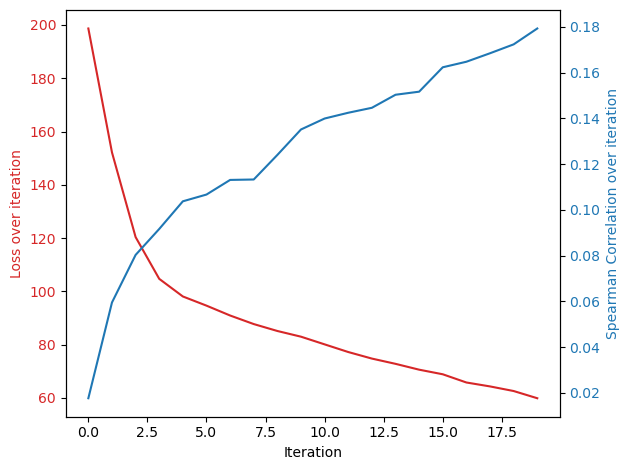

In [37]:
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(losses, color=color)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss over iteration", color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(spearman_corrList, color=color)
ax2.set_ylabel("Spearman Correlation over iteration",color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [38]:
ant_test = torch.tensor([[ 4480,  7146],
        [15031, 20597],
        [ 1750, 25259],
        [ 3020, 20812],
        [  181,  8790],
        [ 1382,  6069],
        [ 2303,  7229],
        [ 1155,  2079],
        [13254,  3149],
        [13234, 16294],
        [  407,  2079],
        [ 4867,  3892],
        [12221,  1997],
        [ 8797,  1690],
        [ 2225, 11508],
        [  760, 16371],
        [14123, 31742],
        [  925,  6753],
        [20576, 25039],
        [10716, 28439],
        [10783, 29953],
        [ 4025, 13192],
        [ 3473,  4619],
        [13848, 23341],
        [17960, 13289],
        [ 4698,  9053],
        [ 1556, 12193],
        [ 1825,  2175],
        [ 5969, 13584],
        [32890,  6928],
        [ 4048,  5254],
        [ 4317,  7296],
        [ 7656,  9228],
        [16199, 19650],
        [  648, 23013],
        [ 4351,  5690],
        [ 2011,   724],
        [ 7128, 23704],
        [  741, 16465],
        [ 9134, 15458],
        [ 4496,  2761],
        [  113,  1411],
        [18804, 24280],
        [14343,  3972],
        [10673,  2175],
        [22933, 27044],
        [ 5197, 15052],
        [ 2173, 10611],
        [15077, 32875],
        [13537, 26564],
        [19186, 12046],
        [ 9703, 11146],
        [ 5108,  3511],
        [ 7206,  2478],
        [26787, 23375],
        [ 3014,  4912],
        [ 9589,  4451],
        [ 1934,  2951],
        [ 2398, 10044],
        [ 2778, 13957],
        [ 6803,  7540],
        [ 7350,  1493],
        [12337,  2383],
        [22749,  6414]])


ant_neg = run_negative_extraction(model_zero, ant_test, synonym=False)
tl = torch.empty((0,))
tr = torch.empty((0,))
for pair in ant_test:
    left_tensor = torch.tensor(ant_neg[pair[0].item()])
    tl = torch.cat((tl, left_tensor.unsqueeze(0)), 0)
    
tl

tensor([ 3473.,  1155.,  2761., 17960., 19186.,  7146., 25259.,  1690., 13234.,
        13254.,  1934.,  1690., 12046.,  7128., 10673., 10673., 13254.,  5254.,
        22933.,  1997., 13584.,  6928.,  4480.,  1556.,  3020.,  1690., 13848.,
         2383.,  9134., 10611.,  9228.,  7206.,  2175.,  4480., 22749.,  6069.,
         7350.,  8797., 31742.,  4496.,  9134., 31742.,  1493., 25259.,   760.,
         1934., 10783., 15052.,  6069.,  6414.,  7206., 10611.,  6753., 19186.,
        13254., 19186., 13289., 22933.,  7350.,  4912.,  5108.,  2011., 19650.,
          648.])

#### 4.4 Évaluation du modèle de zéro et comparaison avec GloVe (5 points)

Comparez le modèle de zéro après l'entraînement à GloVe (résultat de la partie 2.4) en termes de corrélation de Spearman sur le jeu de validation. Quelle méthode est la plus performante ? Pourquoi ?


### 5. Intérêt de GloVe (18 Points)

Dans la section précédente, nous avons entraîné un modèle de zéro.

Nous allons maintenant évaluer si initialiser le modèle avec les plongements de GloVe permet d'améliorer les performances.

#### 5.1 Initialisation avec GloVe (6 points)

Entraînez le modèle `model_fine_tuned`, mais cette fois en ititialisant directement avec les plongements du modèle pré-entraîné GloVe.

On utilisera Adam comme optimiseur.

In [39]:
# TODO
model_fine_tuned = ContrastiveWordEmbeddingModel(glove_embeddings,device=device)
optimizer = optim.Adam(model_fine_tuned.parameters(), lr=LEARNING_RATE)

In [40]:
spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

# TODO
losses = []
spearman_corrList = []
for epoch in tqdm(range(NUM_EPOCHS), desc="epoch"):
    model_fine_tuned.train()
    temp_losses = 0
    for syn, ant in tqdm(zip(syn_data_loader, ant_data_loader), desc="dataloaders"):
        #print(syn)
        
        
        loss = forward(model_fine_tuned, syn, ant)
        
        optimizer.zero_grad()
        
        
        loss.backward()
        temp_losses += loss
        
        optimizer.step()

    
    losses.append((temp_losses/(len(syn_data_loader)+len(ant_data_loader))).item())
    spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
    spearman_corrList += [evaluate(model_fine_tuned,evaluation_simlex,glove_word_to_index)]


spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'After training, Spearman Correlation: {spearman_corrList[-1]:.4f}')
print(f'After training, Spearman Correlation: {spearman_corr:.4f}')
# END TODO

Before training, Spearman Correlation: 0.2923


epoch:   0%|          | 0/20 [00:00<?, ?it/s]
dataloaders: 0it [00:00, ?it/s]
dataloaders: 1it [00:00,  4.65it/s]
dataloaders: 2it [00:00,  5.12it/s]
dataloaders: 3it [00:00,  5.34it/s]
dataloaders: 4it [00:00,  5.19it/s]
dataloaders: 5it [00:00,  5.30it/s]
dataloaders: 6it [00:01,  5.33it/s]
dataloaders: 7it [00:01,  5.40it/s]
dataloaders: 8it [00:01,  4.36it/s]
dataloaders: 9it [00:01,  4.39it/s]
dataloaders: 10it [00:02,  4.48it/s]
dataloaders: 11it [00:02,  4.61it/s]
dataloaders: 12it [00:02,  4.55it/s]
dataloaders: 13it [00:02,  4.63it/s]
dataloaders: 14it [00:02,  4.73it/s]
dataloaders: 15it [00:03,  4.67it/s]
dataloaders: 16it [00:03,  4.79it/s]
dataloaders: 17it [00:03,  4.96it/s]
dataloaders: 18it [00:03,  4.84it/s]
dataloaders: 19it [00:03,  4.77it/s]
dataloaders: 20it [00:04,  4.81it/s]
dataloaders: 21it [00:04,  4.77it/s]
dataloaders: 22it [00:04,  4.75it/s]
dataloaders: 23it [00:04,  4.79it/s]
dataloaders: 24it [00:05,  4.80it/s]
dataloaders: 25it [00:05,  4.81it/s]
datalo

dataloaders: 13it [00:03,  3.73it/s]
dataloaders: 14it [00:03,  3.73it/s]
dataloaders: 15it [00:03,  3.81it/s]
dataloaders: 16it [00:03,  3.79it/s]
dataloaders: 17it [00:04,  3.64it/s]
dataloaders: 18it [00:04,  3.63it/s]
dataloaders: 19it [00:04,  3.68it/s]
dataloaders: 20it [00:04,  3.91it/s]
dataloaders: 21it [00:05,  3.81it/s]
dataloaders: 22it [00:05,  3.76it/s]
dataloaders: 23it [00:05,  3.89it/s]
dataloaders: 24it [00:06,  3.81it/s]
dataloaders: 25it [00:06,  3.71it/s]
dataloaders: 26it [00:06,  3.71it/s]
dataloaders: 27it [00:06,  4.02it/s]
dataloaders: 28it [00:07,  4.20it/s]
dataloaders: 29it [00:07,  4.36it/s]
dataloaders: 30it [00:07,  4.53it/s]
dataloaders: 31it [00:07,  4.48it/s]
dataloaders: 32it [00:07,  4.51it/s]
dataloaders: 33it [00:08,  4.74it/s]
dataloaders: 34it [00:08,  4.78it/s]
dataloaders: 35it [00:08,  4.78it/s]
dataloaders: 36it [00:08,  4.85it/s]
dataloaders: 37it [00:08,  5.03it/s]
dataloaders: 38it [00:09,  4.88it/s]
dataloaders: 39it [00:09,  4.81it/s]
d

dataloaders: 27it [00:05,  5.36it/s]
dataloaders: 28it [00:05,  5.31it/s]
dataloaders: 29it [00:05,  5.31it/s]
dataloaders: 30it [00:05,  5.20it/s]
dataloaders: 31it [00:05,  4.65it/s]
dataloaders: 32it [00:06,  4.82it/s]
dataloaders: 33it [00:06,  4.92it/s]
dataloaders: 34it [00:06,  5.04it/s]
dataloaders: 35it [00:06,  5.09it/s]
dataloaders: 36it [00:06,  5.02it/s]
dataloaders: 37it [00:07,  5.10it/s]
dataloaders: 38it [00:07,  5.14it/s]
dataloaders: 39it [00:07,  5.19it/s]
dataloaders: 40it [00:07,  5.08it/s]
dataloaders: 41it [00:07,  4.99it/s]
dataloaders: 42it [00:08,  5.07it/s]
dataloaders: 43it [00:08,  5.10it/s]
dataloaders: 44it [00:08,  5.14it/s]
dataloaders: 45it [00:08,  5.16it/s]
dataloaders: 46it [00:08,  5.11it/s]
dataloaders: 47it [00:09,  5.18it/s]
dataloaders: 48it [00:09,  5.18it/s]
dataloaders: 49it [00:09,  5.21it/s]
dataloaders: 50it [00:09,  5.21it/s]
dataloaders: 51it [00:09,  5.06it/s]
dataloaders: 52it [00:10,  5.06it/s]
dataloaders: 53it [00:10,  5.10it/s]
d

dataloaders: 41it [00:07,  5.38it/s]
dataloaders: 42it [00:08,  5.42it/s]
dataloaders: 43it [00:08,  5.43it/s]
dataloaders: 44it [00:08,  5.42it/s]
dataloaders: 45it [00:08,  5.30it/s]
dataloaders: 46it [00:08,  5.20it/s]
dataloaders: 47it [00:09,  5.17it/s]
dataloaders: 48it [00:09,  5.12it/s]
dataloaders: 49it [00:09,  5.04it/s]
dataloaders: 50it [00:09,  5.04it/s]
dataloaders: 51it [00:09,  5.01it/s]
dataloaders: 52it [00:10,  5.00it/s]
dataloaders: 53it [00:10,  4.91it/s]
dataloaders: 54it [00:10,  4.96it/s]
dataloaders: 55it [00:10,  4.91it/s]
dataloaders: 56it [00:10,  4.97it/s]
dataloaders: 57it [00:11,  4.93it/s]
dataloaders: 58it [00:11,  4.94it/s]
dataloaders: 59it [00:11,  4.93it/s]
dataloaders: 60it [00:11,  4.96it/s]
dataloaders: 61it [00:11,  4.91it/s]
dataloaders: 62it [00:12,  4.99it/s]
dataloaders: 63it [00:12,  5.09it/s]
dataloaders: 64it [00:12,  5.19it/s]
dataloaders: 65it [00:12,  5.14it/s]
dataloaders: 66it [00:12,  5.07it/s]
dataloaders: 67it [00:13,  5.19it/s]
d

dataloaders: 55it [00:10,  5.27it/s]
dataloaders: 56it [00:10,  5.27it/s]
dataloaders: 57it [00:11,  5.22it/s]
dataloaders: 58it [00:11,  5.28it/s]
dataloaders: 59it [00:11,  5.28it/s]
dataloaders: 60it [00:11,  5.29it/s]
dataloaders: 61it [00:11,  5.35it/s]
dataloaders: 62it [00:12,  5.28it/s]
dataloaders: 63it [00:12,  5.30it/s]
dataloaders: 64it [00:12,  5.36it/s]
dataloaders: 65it [00:12,  5.36it/s]
dataloaders: 66it [00:12,  5.35it/s]
dataloaders: 67it [00:12,  5.33it/s]
dataloaders: 68it [00:13,  5.34it/s]
dataloaders: 69it [00:13,  5.39it/s]
dataloaders: 70it [00:13,  5.32it/s]
dataloaders: 71it [00:13,  5.37it/s]
dataloaders: 72it [00:13,  5.25it/s]
dataloaders: 73it [00:14,  5.17it/s]
dataloaders: 74it [00:14,  5.17it/s]
dataloaders: 75it [00:14,  5.24it/s]
dataloaders: 76it [00:14,  5.20it/s]
dataloaders: 77it [00:14,  5.28it/s]
dataloaders: 78it [00:15,  5.32it/s]
dataloaders: 79it [00:15,  5.29it/s]
dataloaders: 80it [00:15,  5.30it/s]
dataloaders: 81it [00:15,  5.32it/s]
d

dataloaders: 69it [00:13,  5.23it/s]
dataloaders: 70it [00:13,  5.32it/s]
dataloaders: 71it [00:13,  5.37it/s]
dataloaders: 72it [00:13,  5.39it/s]
dataloaders: 73it [00:14,  5.44it/s]
dataloaders: 74it [00:14,  5.38it/s]
dataloaders: 75it [00:14,  5.26it/s]
dataloaders: 76it [00:14,  5.31it/s]
dataloaders: 77it [00:14,  5.34it/s]
dataloaders: 78it [00:15,  5.24it/s]
dataloaders: 79it [00:15,  5.31it/s]
dataloaders: 80it [00:15,  5.29it/s]
dataloaders: 81it [00:15,  5.20it/s]
dataloaders: 82it [00:15,  5.26it/s]
dataloaders: 83it [00:16,  5.26it/s]
dataloaders: 84it [00:16,  5.22it/s]
dataloaders: 85it [00:16,  5.24it/s]
dataloaders: 86it [00:16,  5.15it/s]
dataloaders: 87it [00:16,  5.04it/s]
dataloaders: 88it [00:17,  5.04it/s]
dataloaders: 89it [00:17,  4.97it/s]
dataloaders: 90it [00:17,  4.39it/s]
dataloaders: 91it [00:17,  4.55it/s]
dataloaders: 92it [00:17,  4.62it/s]
dataloaders: 93it [00:18,  4.58it/s]
dataloaders: 94it [00:18,  4.66it/s]
dataloaders: 95it [00:18,  4.71it/s]
d

dataloaders: 83it [00:16,  4.55it/s]
dataloaders: 84it [00:16,  4.74it/s]
dataloaders: 85it [00:16,  4.82it/s]
dataloaders: 86it [00:17,  4.56it/s]
dataloaders: 87it [00:17,  4.65it/s]
dataloaders: 88it [00:17,  4.79it/s]
dataloaders: 89it [00:17,  4.85it/s]
dataloaders: 90it [00:17,  4.79it/s]
dataloaders: 91it [00:18,  4.47it/s]
dataloaders: 92it [00:18,  4.54it/s]
dataloaders: 93it [00:18,  4.58it/s]
dataloaders: 94it [00:18,  4.64it/s]
dataloaders: 95it [00:19,  4.67it/s]
dataloaders: 96it [00:19,  4.81it/s]
dataloaders: 97it [00:19,  4.82it/s]
dataloaders: 98it [00:19,  4.94it/s]
dataloaders: 99it [00:19,  4.77it/s]
dataloaders: 100it [00:20,  4.67it/s]
dataloaders: 101it [00:20,  4.57it/s]
dataloaders: 102it [00:20,  4.69it/s]
dataloaders: 103it [00:20,  4.76it/s]
dataloaders: 104it [00:20,  4.85it/s]
dataloaders: 105it [00:21,  5.00it/s]
dataloaders: 106it [00:21,  5.12it/s]
dataloaders: 107it [00:21,  5.12it/s]
dataloaders: 108it [00:21,  5.20it/s]
dataloaders: 109it [00:21,  5

dataloaders: 97it [00:20,  5.16it/s]
dataloaders: 98it [00:20,  5.23it/s]
dataloaders: 99it [00:20,  5.14it/s]
dataloaders: 100it [00:20,  5.17it/s]
dataloaders: 101it [00:20,  5.19it/s]
dataloaders: 102it [00:21,  5.24it/s]
dataloaders: 103it [00:21,  5.27it/s]
dataloaders: 104it [00:21,  5.24it/s]
dataloaders: 105it [00:21,  5.12it/s]
dataloaders: 106it [00:21,  5.11it/s]
dataloaders: 107it [00:22,  5.04it/s]
dataloaders: 108it [00:22,  4.96it/s]
dataloaders: 109it [00:22,  4.75it/s]
dataloaders: 110it [00:22,  4.31it/s]
dataloaders: 111it [00:23,  4.48it/s]
dataloaders: 112it [00:23,  4.55it/s]
dataloaders: 113it [00:23,  4.58it/s]
dataloaders: 114it [00:23,  4.72it/s]
dataloaders: 115it [00:23,  4.67it/s]
dataloaders: 116it [00:24,  4.71it/s]
dataloaders: 117it [00:24,  4.77it/s]
dataloaders: 118it [00:24,  4.82it/s]
dataloaders: 119it [00:24,  4.77it/s]
dataloaders: 120it [00:24,  4.83it/s]
dataloaders: 121it [00:25,  4.98it/s]
dataloaders: 122it [00:25,  5.08it/s]
dataloaders: 12

dataloaders: 111it [00:22,  4.91it/s]
dataloaders: 112it [00:22,  4.84it/s]
dataloaders: 113it [00:22,  4.87it/s]
dataloaders: 114it [00:22,  4.94it/s]
dataloaders: 115it [00:22,  4.93it/s]
dataloaders: 116it [00:23,  4.90it/s]
dataloaders: 117it [00:23,  4.89it/s]
dataloaders: 118it [00:23,  4.89it/s]
dataloaders: 119it [00:23,  4.95it/s]
dataloaders: 120it [00:23,  4.83it/s]
dataloaders: 121it [00:24,  4.83it/s]
dataloaders: 122it [00:24,  4.84it/s]
dataloaders: 123it [00:24,  4.78it/s]
dataloaders: 124it [00:24,  4.89it/s]
dataloaders: 125it [00:24,  4.94it/s]
dataloaders: 126it [00:25,  4.99it/s]
dataloaders: 127it [00:25,  4.96it/s]
dataloaders: 128it [00:25,  4.94it/s]
dataloaders: 129it [00:25,  4.87it/s]
dataloaders: 130it [00:25,  4.89it/s]
dataloaders: 131it [00:26,  4.94it/s]
dataloaders: 132it [00:26,  4.95it/s]
dataloaders: 133it [00:26,  4.96it/s]
dataloaders: 134it [00:26,  4.93it/s]
dataloaders: 135it [00:27,  4.92it/s]
dataloaders: 136it [00:27,  4.99it/s]
dataloaders:

dataloaders: 125it [00:25,  4.92it/s]
dataloaders: 126it [00:26,  4.84it/s]
dataloaders: 127it [00:26,  4.83it/s]
dataloaders: 128it [00:26,  4.80it/s]
dataloaders: 129it [00:26,  4.40it/s]
dataloaders: 130it [00:27,  4.57it/s]
dataloaders: 131it [00:27,  4.54it/s]
dataloaders: 132it [00:27,  4.65it/s]
dataloaders: 133it [00:27,  4.69it/s]
dataloaders: 134it [00:27,  4.63it/s]
dataloaders: 135it [00:28,  4.57it/s]
dataloaders: 136it [00:28,  4.67it/s]
dataloaders: 137it [00:28,  4.65it/s]
dataloaders: 138it [00:28,  4.63it/s]
dataloaders: 139it [00:28,  4.69it/s]
dataloaders: 140it [00:29,  4.59it/s]
dataloaders: 141it [00:29,  4.67it/s]
dataloaders: 142it [00:29,  4.70it/s]
dataloaders: 143it [00:29,  4.67it/s]
dataloaders: 144it [00:29,  4.77it/s]
dataloaders: 145it [00:30,  4.82it/s]
dataloaders: 146it [00:30,  4.86it/s]
dataloaders: 147it [00:30,  4.81it/s]
dataloaders: 148it [00:30,  4.92it/s]
dataloaders: 149it [00:30,  5.03it/s]
dataloaders: 150it [00:31,  5.11it/s]
dataloaders:

dataloaders: 139it [00:27,  5.15it/s]
dataloaders: 140it [00:28,  5.15it/s]
dataloaders: 141it [00:28,  4.95it/s]
dataloaders: 142it [00:28,  4.95it/s]
dataloaders: 143it [00:28,  5.04it/s]
dataloaders: 144it [00:28,  5.12it/s]
dataloaders: 145it [00:29,  4.95it/s]
dataloaders: 146it [00:29,  5.07it/s]
dataloaders: 147it [00:29,  4.66it/s]
dataloaders: 148it [00:29,  4.78it/s]
dataloaders: 149it [00:30,  4.88it/s]
dataloaders: 150it [00:30,  4.91it/s]
dataloaders: 151it [00:30,  5.00it/s]
dataloaders: 152it [00:30,  4.99it/s]
dataloaders: 153it [00:30,  5.07it/s]
dataloaders: 154it [00:31,  5.13it/s]
dataloaders: 155it [00:31,  5.18it/s]
dataloaders: 156it [00:31,  5.21it/s]
dataloaders: 157it [00:31,  5.11it/s]
dataloaders: 158it [00:31,  5.17it/s]
dataloaders: 159it [00:31,  5.22it/s]
dataloaders: 160it [00:32,  5.17it/s]
dataloaders: 161it [00:32,  5.19it/s]
dataloaders: 162it [00:32,  5.11it/s]
dataloaders: 163it [00:32,  5.12it/s]
dataloaders: 164it [00:32,  5.10it/s]
dataloaders:

dataloaders: 153it [00:31,  4.11it/s]
dataloaders: 154it [00:31,  4.21it/s]
dataloaders: 155it [00:31,  4.24it/s]
dataloaders: 156it [00:32,  4.38it/s]
dataloaders: 157it [00:32,  4.42it/s]
dataloaders: 158it [00:32,  4.45it/s]
dataloaders: 159it [00:32,  4.56it/s]
dataloaders: 160it [00:32,  4.66it/s]
dataloaders: 161it [00:33,  4.66it/s]
dataloaders: 162it [00:33,  4.74it/s]
dataloaders: 163it [00:33,  4.82it/s]
dataloaders: 164it [00:33,  4.89it/s]
dataloaders: 165it [00:33,  4.80it/s]
dataloaders: 166it [00:34,  4.89it/s]
dataloaders: 167it [00:34,  4.91it/s]
dataloaders: 168it [00:34,  4.87it/s]
dataloaders: 169it [00:34,  4.87it/s]
dataloaders: 170it [00:34,  4.92it/s]
dataloaders: 171it [00:35,  4.86it/s]
dataloaders: 172it [00:35,  4.84it/s]
dataloaders: 173it [00:35,  4.84it/s]
dataloaders: 174it [00:35,  4.88it/s]
dataloaders: 175it [00:36,  4.95it/s]
dataloaders: 176it [00:36,  4.91it/s]
dataloaders: 177it [00:36,  5.00it/s]
dataloaders: 178it [00:36,  5.00it/s]
dataloaders:

dataloaders: 167it [00:34,  5.06it/s]
dataloaders: 168it [00:34,  5.05it/s]
dataloaders: 169it [00:34,  5.05it/s]
dataloaders: 170it [00:34,  4.86it/s]
dataloaders: 171it [00:34,  4.90it/s]
dataloaders: 172it [00:35,  4.92it/s]
dataloaders: 173it [00:35,  5.00it/s]
dataloaders: 174it [00:35,  4.91it/s]
dataloaders: 175it [00:35,  4.98it/s]
dataloaders: 176it [00:35,  5.08it/s]
dataloaders: 177it [00:36,  5.11it/s]
dataloaders: 178it [00:36,  5.15it/s]
dataloaders: 179it [00:36,  5.08it/s]
dataloaders: 180it [00:36,  5.09it/s]
dataloaders: 181it [00:36,  5.14it/s]
dataloaders: 182it [00:36,  5.16it/s]
dataloaders: 183it [00:37,  4.91it/s]
dataloaders: 184it [00:37,  4.86it/s]
dataloaders: 185it [00:37,  4.89it/s]
dataloaders: 186it [00:37,  4.92it/s]
epoch:  65%|██████▌   | 13/20 [08:09<04:26, 38.05s/it]
dataloaders: 0it [00:00, ?it/s]
dataloaders: 1it [00:00,  4.64it/s]
dataloaders: 2it [00:00,  4.72it/s]
dataloaders: 3it [00:00,  4.84it/s]
dataloaders: 4it [00:00,  4.75it/s]
dataloade

dataloaders: 181it [00:36,  5.01it/s]
dataloaders: 182it [00:37,  5.07it/s]
dataloaders: 183it [00:37,  5.04it/s]
dataloaders: 184it [00:37,  4.99it/s]
dataloaders: 185it [00:37,  4.92it/s]
dataloaders: 186it [00:37,  4.91it/s]
epoch:  70%|███████   | 14/20 [08:47<03:48, 38.07s/it]
dataloaders: 0it [00:00, ?it/s]
dataloaders: 1it [00:00,  4.63it/s]
dataloaders: 2it [00:00,  4.89it/s]
dataloaders: 3it [00:00,  4.93it/s]
dataloaders: 4it [00:00,  4.96it/s]
dataloaders: 5it [00:01,  4.38it/s]
dataloaders: 6it [00:01,  4.63it/s]
dataloaders: 7it [00:01,  4.73it/s]
dataloaders: 8it [00:01,  4.78it/s]
dataloaders: 9it [00:01,  4.94it/s]
dataloaders: 10it [00:02,  4.97it/s]
dataloaders: 11it [00:02,  4.89it/s]
dataloaders: 12it [00:02,  4.89it/s]
dataloaders: 13it [00:02,  4.97it/s]
dataloaders: 14it [00:02,  5.05it/s]
dataloaders: 15it [00:03,  4.92it/s]
dataloaders: 16it [00:03,  4.98it/s]
dataloaders: 17it [00:03,  5.00it/s]
dataloaders: 18it [00:03,  4.99it/s]
dataloaders: 19it [00:03,  4

dataloaders: 7it [00:01,  4.58it/s]
dataloaders: 8it [00:01,  4.65it/s]
dataloaders: 9it [00:01,  4.59it/s]
dataloaders: 10it [00:02,  4.63it/s]
dataloaders: 11it [00:02,  4.60it/s]
dataloaders: 12it [00:02,  4.67it/s]
dataloaders: 13it [00:02,  4.73it/s]
dataloaders: 14it [00:03,  4.80it/s]
dataloaders: 15it [00:03,  4.69it/s]
dataloaders: 16it [00:03,  4.82it/s]
dataloaders: 17it [00:03,  4.96it/s]
dataloaders: 18it [00:03,  5.03it/s]
dataloaders: 19it [00:04,  4.91it/s]
dataloaders: 20it [00:04,  4.99it/s]
dataloaders: 21it [00:04,  4.99it/s]
dataloaders: 22it [00:04,  5.01it/s]
dataloaders: 23it [00:04,  4.91it/s]
dataloaders: 24it [00:05,  4.93it/s]
dataloaders: 25it [00:05,  4.94it/s]
dataloaders: 26it [00:05,  4.83it/s]
dataloaders: 27it [00:05,  4.81it/s]
dataloaders: 28it [00:05,  4.78it/s]
dataloaders: 29it [00:06,  4.75it/s]
dataloaders: 30it [00:06,  4.66it/s]
dataloaders: 31it [00:06,  4.66it/s]
dataloaders: 32it [00:06,  4.63it/s]
dataloaders: 33it [00:06,  4.61it/s]
data

dataloaders: 21it [00:04,  4.98it/s]
dataloaders: 22it [00:04,  4.83it/s]
dataloaders: 23it [00:04,  4.52it/s]
dataloaders: 24it [00:05,  4.72it/s]
dataloaders: 25it [00:05,  4.89it/s]
dataloaders: 26it [00:05,  4.90it/s]
dataloaders: 27it [00:05,  4.85it/s]
dataloaders: 28it [00:05,  4.90it/s]
dataloaders: 29it [00:06,  5.04it/s]
dataloaders: 30it [00:06,  4.92it/s]
dataloaders: 31it [00:06,  4.96it/s]
dataloaders: 32it [00:06,  4.88it/s]
dataloaders: 33it [00:06,  4.89it/s]
dataloaders: 34it [00:07,  4.87it/s]
dataloaders: 35it [00:07,  4.98it/s]
dataloaders: 36it [00:07,  4.98it/s]
dataloaders: 37it [00:07,  4.88it/s]
dataloaders: 38it [00:07,  4.90it/s]
dataloaders: 39it [00:08,  4.93it/s]
dataloaders: 40it [00:08,  4.90it/s]
dataloaders: 41it [00:08,  5.01it/s]
dataloaders: 42it [00:08,  4.97it/s]
dataloaders: 43it [00:08,  4.91it/s]
dataloaders: 44it [00:09,  4.83it/s]
dataloaders: 45it [00:09,  4.88it/s]
dataloaders: 46it [00:09,  4.97it/s]
dataloaders: 47it [00:09,  4.99it/s]
d

dataloaders: 35it [00:07,  4.67it/s]
dataloaders: 36it [00:07,  4.49it/s]
dataloaders: 37it [00:07,  4.49it/s]
dataloaders: 38it [00:07,  4.51it/s]
dataloaders: 39it [00:08,  4.47it/s]
dataloaders: 40it [00:08,  4.47it/s]
dataloaders: 41it [00:08,  3.80it/s]
dataloaders: 42it [00:08,  4.03it/s]
dataloaders: 43it [00:09,  4.21it/s]
dataloaders: 44it [00:09,  4.28it/s]
dataloaders: 45it [00:09,  3.90it/s]
dataloaders: 46it [00:09,  3.90it/s]
dataloaders: 47it [00:10,  3.80it/s]
dataloaders: 48it [00:10,  3.97it/s]
dataloaders: 49it [00:10,  4.05it/s]
dataloaders: 50it [00:10,  4.18it/s]
dataloaders: 51it [00:11,  4.20it/s]
dataloaders: 52it [00:11,  4.33it/s]
dataloaders: 53it [00:11,  4.52it/s]
dataloaders: 54it [00:11,  4.51it/s]
dataloaders: 55it [00:11,  4.54it/s]
dataloaders: 56it [00:12,  4.61it/s]
dataloaders: 57it [00:12,  4.51it/s]
dataloaders: 58it [00:12,  4.44it/s]
dataloaders: 59it [00:12,  4.44it/s]
dataloaders: 60it [00:13,  4.16it/s]
dataloaders: 61it [00:13,  4.33it/s]
d

dataloaders: 49it [00:11,  4.28it/s]
dataloaders: 50it [00:11,  4.36it/s]
dataloaders: 51it [00:11,  4.44it/s]
dataloaders: 52it [00:11,  4.44it/s]
dataloaders: 53it [00:12,  4.43it/s]
dataloaders: 54it [00:12,  4.55it/s]
dataloaders: 55it [00:12,  4.57it/s]
dataloaders: 56it [00:12,  4.65it/s]
dataloaders: 57it [00:13,  4.70it/s]
dataloaders: 58it [00:13,  4.65it/s]
dataloaders: 59it [00:13,  4.53it/s]
dataloaders: 60it [00:13,  4.55it/s]
dataloaders: 61it [00:13,  4.66it/s]
dataloaders: 62it [00:14,  4.71it/s]
dataloaders: 63it [00:14,  4.57it/s]
dataloaders: 64it [00:14,  4.70it/s]
dataloaders: 65it [00:14,  4.77it/s]
dataloaders: 66it [00:14,  4.79it/s]
dataloaders: 67it [00:15,  4.88it/s]
dataloaders: 68it [00:15,  4.87it/s]
dataloaders: 69it [00:15,  4.65it/s]
dataloaders: 70it [00:15,  4.56it/s]
dataloaders: 71it [00:16,  4.58it/s]
dataloaders: 72it [00:16,  4.58it/s]
dataloaders: 73it [00:16,  4.62it/s]
dataloaders: 74it [00:16,  4.55it/s]
dataloaders: 75it [00:16,  4.57it/s]
d

dataloaders: 63it [00:13,  5.01it/s]
dataloaders: 64it [00:13,  4.96it/s]
dataloaders: 65it [00:13,  4.97it/s]
dataloaders: 66it [00:13,  5.00it/s]
dataloaders: 67it [00:13,  4.93it/s]
dataloaders: 68it [00:14,  4.92it/s]
dataloaders: 69it [00:14,  4.98it/s]
dataloaders: 70it [00:14,  5.02it/s]
dataloaders: 71it [00:14,  4.92it/s]
dataloaders: 72it [00:14,  4.81it/s]
dataloaders: 73it [00:15,  4.27it/s]
dataloaders: 74it [00:15,  4.22it/s]
dataloaders: 75it [00:15,  4.28it/s]
dataloaders: 76it [00:15,  4.29it/s]
dataloaders: 77it [00:16,  4.11it/s]
dataloaders: 78it [00:16,  4.28it/s]
dataloaders: 79it [00:16,  4.43it/s]
dataloaders: 80it [00:16,  4.31it/s]
dataloaders: 81it [00:17,  4.35it/s]
dataloaders: 82it [00:17,  4.40it/s]
dataloaders: 83it [00:17,  4.50it/s]
dataloaders: 84it [00:17,  4.58it/s]
dataloaders: 85it [00:17,  4.44it/s]
dataloaders: 86it [00:18,  4.45it/s]
dataloaders: 87it [00:18,  4.55it/s]
dataloaders: 88it [00:18,  4.67it/s]
dataloaders: 89it [00:18,  4.63it/s]
d

After training, Spearman Correlation: 0.4846
After training, Spearman Correlation: 0.4846


#### 5.2 Courbes d'entraînement (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

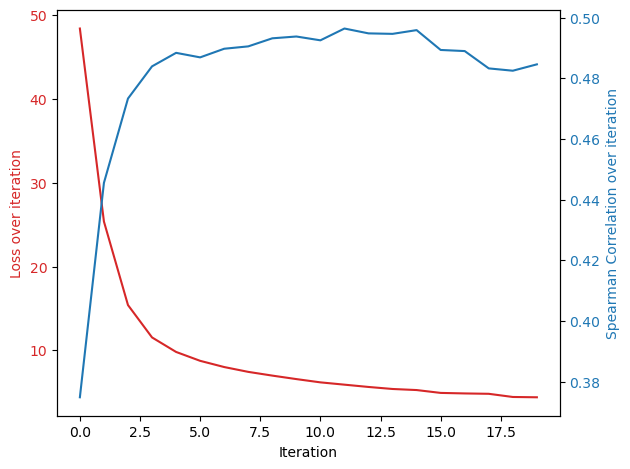

In [41]:
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(losses, color=color)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss over iteration", color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(spearman_corrList, color=color)
ax2.set_ylabel("Spearman Correlation over iteration",color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#### 5.3 Vérification sur un exemple (3 points)

Avec le modèle `model_fine_tuned`, calculez la similarité cosinus entre 'fast' et 'slow' et entre 'fast' et 'rapid'. Commentez les résultats en les comparant avec ceux de la partie 1.4.

In [42]:
nDim = 300
fastEmbedding = torch.reshape(model_fine_tuned.embeddings.weight[word_to_index['fast']],(1,nDim))
slowEmbedding = torch.reshape(model_fine_tuned.embeddings.weight[word_to_index['slow']],(1,nDim))
rapidEmbedding = torch.reshape(model_fine_tuned.embeddings.weight[word_to_index['rapid']],(1,nDim))

fastSlowRapidSimilarity = cosine_similarity(fastEmbedding, torch.cat((slowEmbedding,rapidEmbedding),0))

print(f'{"":^10} |{"slow":^10} |{"rapid":^10}')
fastSlowStr = f'{float(fastSlowRapidSimilarity[0,0]):.5f}'
fastRapidStr = f'{float(fastSlowRapidSimilarity[0,1]):.5f}'
print(f'{"fast":^10} |{fastSlowStr:^10} |{fastRapidStr:^10}')

           |   slow    |  rapid   
   fast    | 0.13076   | 0.38952  


#### 5.4 Analyse, comparaison, conclusion (5 points)

Comparez les performances des trois modèles (GloVe, zéro, fine-tuned). Quelle méthode est la plus performante ? Pourquoi ?


## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs